In this notebook, we are goin to compute wavelet time-frequency spectrograms for events, baselined to other epochs (e.g. fixation crosses) from the task. We are also going to focus on saving the data out in an efficient matter for subsequent analysis

In [74]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [75]:
import numpy as np
import mne
import mne_connectivity
import pactools
from mne_connectivity import phase_slope_index, seed_target_indices, spectral_connectivity_epochs
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import fooof
# Import plotting functions
from fooof.plts.spectra import plot_spectrum, plot_spectra
# Import the FOOOF object
from fooof import FOOOF
from fooof import FOOOFGroup
import os 
import joblib
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import warnings 

# I only want to see warnings once
warnings.filterwarnings('ignore')

from joblib import delayed, Parallel
from statsmodels.stats import multitest

In [76]:
# Set some plot defaults for matplotlib (when not using seaborn): 

import  matplotlib.font_manager

path = '/sc/arion/projects/guLab/Salman/Arial.ttf'
matplotlib.font_manager.fontManager.addfont(path)

prop = matplotlib.font_manager.FontProperties(fname=path)

# Set the default font family to the registered custom font
plt.rcParams['font.family'] = prop.get_name()

# Rest of your customization code
plt.rcParams['font.size'] = 20
plt.rcParams['lines.linewidth'] = 1



Note: If you have installed this package in editable form on Minerva, you must append the local path! This is because Minerva requires that you point your package installs away from the local directory for space reasons, but editable packages have to be installed locally.

In [77]:
import sys
sys.path.append('/hpc/users/qasims01/resources/LFPAnalysis')

In [78]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils, oscillation_utils, statistics_utils


## First, get the behavior data

This is from another notebook with a kernel and environment specifically for beahvior

In [79]:
base_dir = '/sc/arion' # this is the root directory for most un-archived data and results
load_dir = f'{base_dir}/work/qasims01/MemoryBanditData/EMU'

# Load the demographics data to get information about who has run the task
demo_file = f'{base_dir}/projects/guLab/Salman/EMU/MemoryBanditsDatabase.xlsx'
demo_data = pd.read_excel(demo_file, engine='openpyxl')
subj_df = demo_data[(demo_data.LongVersion==1) & (demo_data.Minerva==1)]

# Let's get rid of Iowa patients for now 

# subj_df = subj_df[subj_df.Site=='UI']

days = ['Day1', 'Day2']
subj_ids = subj_df.MSSMCode.values
subj_formats = subj_df.format.values
subj_sites = subj_df.Site.values
subj_days = subj_df.Day2.values

In [80]:
# load behavioral data
learn_df = pd.read_csv(f'{load_dir}/learn_df.csv')
combined_df = pd.read_csv(f'{load_dir}/combined_df.csv')

# Filter just to the participants in this notebook
learn_df = learn_df[learn_df.participant.isin(subj_ids)]
combined_df = combined_df[combined_df.participant.isin(subj_ids)]


# I enter the day information in stupidly 
combined_df.condition = combined_df.condition.apply(lambda x: 'Day1' if x=='day_1' else 'Day2' if x=='day_2' else np.nan)
combined_df['recog_time'] = combined_df['recog_time'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)
combined_df['baseline_start_mem'] = combined_df['baseline_start_mem'].apply(lambda x: float(x) if (~pd.isna(x)) & (x!='None') else x)

# # add RPE to the combined df dataframe: 

combined_df['rpe'] = np.nan
for ix, row in learn_df.iterrows():
    combined_df.loc[(combined_df.img_path==row.img_path) & (combined_df.participant==row.participant), 'rpe'] = row.rpe


## Wavelet TFRs

Here, we will plot some basic TFRs of our behaviorally-locked analysis using a wavelet transform. We can also use these to compute the inter-trial phase coherence (ITC). 

Let's set some parameters first


## Compute for decision-making first

In [81]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict


evs = {'gamble_start':[-1.0, 0], 
       'feedback_start': [0, 1.5],
       'baseline_start': [0, 0.75]}

baseline_ev = 'baseline_start'
analysis_evs = ['feedback_start']

day = 'Day1'

for i in analysis_evs: 
    if i not in evs.keys(): 
        raise ValueError('This analysis event is not in the dictionary')
        
# Define parameters for TFR: 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))

In [82]:
# # Load one person's data 
# subj_id = 'MS012'
# day = 'Day1'
# save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'

In [83]:
# feedback_epochs_reref = mne.read_epochs(f'{save_path}/feedback_start-epo.fif', preload=True)
# baseline_epochs_reref = mne.read_epochs(f'{save_path}/baseline_start-epo.fif', preload=True)

In [84]:
# # Merge in the behavioral data for the different tasks

# evs_for_dm_only = behav_data[(behav_data.participant==subj_id)]

# evs_for_dm_and_mem = combined_df[(combined_df.participant==subj_id)].sort_values(by=['trials_gamble']).dropna(subset=['trials_gamble']).reset_index(drop=True)


# ied_data = feedback_epochs_reref.metadata.copy()
# event_metadata = pd.concat([evs_for_dm_only, ied_data], axis=1)
# feedback_epochs_reref.metadata = event_metadata

# ied_data = baseline_epochs_reref.metadata.copy()
# event_metadata = pd.concat([evs_for_dm_only, ied_data], axis=1)
# baseline_epochs_reref.metadata = event_metadata



First, compute the baseline power:

In [85]:
baseline_power_epochs = {f'{a}' : {f'{baseline_ev}':[]} for a in subj_ids} 

In [86]:
# Compute baseline_power
for subj_id in subj_ids[0:1]:
        
    save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
    baseline_epochs_reref = mne.read_epochs(f'{save_path}/{baseline_ev}-epo.fif', preload=True)
    
    # Let's make sure we only do this for good channels
    good_chans = [x for x in baseline_epochs_reref.ch_names if x not in baseline_epochs_reref.info['bads']]
    picks = [x for x in good_chans]

    pow_struct = np.nan * np.ones([baseline_epochs_reref._data.shape[0], 
                           baseline_epochs_reref._data.shape[1], len(freqs), 
                           baseline_epochs_reref._data.shape[-1]])

    good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(baseline_epochs_reref)
    
#     progress_bar = tqdm(np.arange(baseline_epochs_reref._data.shape[1]), ascii=True, desc='Computing TFR')
    
    for ch_ix, ch_name in enumerate(baseline_epochs_reref.ch_names): 
        ch_data = baseline_epochs_reref._data[:, ch_ix:ch_ix+1, :]
#         bad_epochs  = np.where(baseline_epochs_reref.metadata[baseline_epochs_reref.ch_names[ch_ix]].notnull())[0]
#         good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
        ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
        ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=baseline_epochs_reref.info['sfreq'], 
                                             freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                            use_fft=True, output='power', n_jobs=-1)

        pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]
    
    temp_pow = mne.time_frequency.EpochsTFR(baseline_epochs_reref.info, pow_struct, 
                                            baseline_epochs_reref.times, freqs)
    
    temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1])

    baseline_power_epochs[subj_id][baseline_ev] = temp_pow

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/baseline_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 28 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   13.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


 - baseline_power_epochs: a dictionary containing all of your subjects' baseline TFR, with the buffer cropped out

Next, compute the power for the analysis events and BASELINE it using the baseline epochs: 

In [121]:
power_epochs = {f'{a}' : {f'{b}':[] for b in analysis_evs} for a in subj_ids} 

Use the metadata to assign conditions to parse your epochs!

In [137]:
for subj_id in subj_ids:
    filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'
    if not os.path.exists(filepath):
        os.makedirs(filepath)
        
    for event in analysis_evs:
        save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
        event_epochs_reref = mne.read_epochs(f'{save_path}/{event}-epo.fif', preload=True)
        ch_names = event_epochs_reref.ch_names
        #epochs_all_subjs_all_evs[subj_id][event]
            
        # Let's make sure we only do this for good channels
        good_chans = [x for x in event_epochs_reref.ch_names if x not in event_epochs_reref.info['bads']]
        picks = [x for x in good_chans]
        
        pow_struct = np.nan * np.ones([event_epochs_reref._data.shape[0], 
                               event_epochs_reref._data.shape[1], len(freqs), 
                               event_epochs_reref._data.shape[-1]])
    
        good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(event_epochs_reref)

#         progress_bar = tqdm(np.arange(event_epochs_reref._data.shape[1]), ascii=True, desc='Baselining TFR')

        for ch_ix, ch_name in enumerate(event_epochs_reref.ch_names): 
            ch_data = event_epochs_reref._data[:, ch_ix:ch_ix+1, :]
#             bad_epochs  = np.where(event_epochs_reref.metadata[event_epochs_reref.ch_names[ch_ix]].notnull())[0]
#             good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
            ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
            ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=event_epochs_reref.info['sfreq'], 
                                                freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                                use_fft=True, output='power', n_jobs=-1)

            pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]
        
        temp_pow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, pow_struct, 
                                                event_epochs_reref.times, freqs)
        
        temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
        
#         Baseline by all the baseline periods in the session
#         baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
#                                                           baseline_mne=baseline_power_epochs[subj_id][baseline_ev], 
#                                                           mode='zscore', 
#                                                           trialwise=False, 
#                                                           baseline_only=True)


        baseline_corrected_power = lfp_preprocess_utils.baseline_TFR_permute(data=temp_pow.data, 
                                                                             baseline_mne=baseline_power_epochs[subj_id][baseline_ev], 
                                                                             mode='zscore', num_samples=10000)
        # Let's nan out absurd z-scores 
#         absurdity_threshold = 10
#         baseline_corrected_power[baseline_corrected_power>absurdity_threshold] = np.nan
        zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power, 
                                        temp_pow.times, freqs)
        
        zpow.metadata = event_epochs_reref.metadata
        
        zpow.save(f'{filepath}/{event}-tfr.h5', overwrite=True)
        
        # power_epochs[subj_id][event] = zpow
        
        # Save out the baselined TFR epochs:
        # power_epochs[subj_id][event].save(f'{filepath}/{event}-tfr.h5', overwrite=True)

        

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 28 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    6.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 28 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 38 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 38 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.


Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 6 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 35 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 35 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 24 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 24 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 100 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
Adding metadata with 100 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 34 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 34 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 29 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 29 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 18 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 65 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
Adding metadata with 65 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI003/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 60 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.


Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 60 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS024/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 60 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.


Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 60 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 58 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.


Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 58 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 22 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 22 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 55 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 55 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 37 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 37 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI004/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 90 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


Not setting metadata
Adding metadata with 90 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS034/neural/Day1/feedback_start-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 39 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 39 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 58 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.


Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 58 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 52 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 52 columns
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 45 columns
80 matching events found
No baseline correction applied
0 projection items activated


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished


Not setting metadata
Adding metadata with 45 columns


 - power_epochs: a dictionary containing all of your subjects' event TFR, with the buffer cropped out and NORMALIZED with the baseline + event period 

## Do the same for memory epochs

In [9]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict

evs = {'recog_time': [-1.0, 0.0],
       'baseline_start_mem': [0, 0.75]}

baseline_ev = 'baseline_start_mem'
analysis_evs = ['recog_time']

day = 'Day1'

for i in analysis_evs: 
    if i not in evs.keys(): 
        raise ValueError('This analysis event is not in the dictionary')
        
# Define parameters for TFR: 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))

In [10]:
baseline_power_epochs = {f'{a}' : {f'{baseline_ev}':[]} for a in subj_ids} 

In [11]:
# Compute baseline_power
for subj_id in subj_ids:
        
    save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
    baseline_epochs_reref = mne.read_epochs(f'{save_path}/{baseline_ev}-epo.fif', preload=True)
    
    # Let's make sure we only do this for good channels
    good_chans = [x for x in baseline_epochs_reref.ch_names if x not in baseline_epochs_reref.info['bads']]
    picks = [x for x in good_chans]

    pow_struct = np.nan * np.ones([baseline_epochs_reref._data.shape[0], 
                           baseline_epochs_reref._data.shape[1], len(freqs), 
                           baseline_epochs_reref._data.shape[-1]])

    progress_bar = tqdm(np.arange(baseline_epochs_reref._data.shape[1]), ascii=True, desc='Computing TFR')
    
    for ch_ix in progress_bar: 
        ch_data = baseline_epochs_reref._data[:, ch_ix:ch_ix+1, :]
        bad_epochs  = np.where(baseline_epochs_reref.metadata[baseline_epochs_reref.ch_names[ch_ix]].notnull())[0]
        good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
        ch_data = np.delete(ch_data, bad_epochs, axis=0)
        ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=baseline_epochs_reref.info['sfreq'], 
                                             freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                            use_fft=True, output='power', n_jobs=-1)

        pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]

    temp_pow = mne.time_frequency.EpochsTFR(baseline_epochs_reref.info, pow_struct, 
                                            baseline_epochs_reref.times, freqs)
    
    temp_pow.crop(tmin=evs[baseline_ev][0], tmax=evs[baseline_ev][1])

    baseline_power_epochs[subj_id][baseline_ev] = temp_pow

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 28 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/28 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.5s finished
Computing TFR:   4%|3         | 1/28 [00:11<05:12, 11.58s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
Computing TFR:   7%|7         | 2/28 [00:12<02:19,  5.38s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
Computing TFR:  11%|#         | 3/28 [00:13<01:24,  3.37s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
Computing TFR:  14%|#4        | 4/28 [00:14<00:58,  2.42s/it][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 38 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/38 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|2         | 1/38 [00:00<00:09,  3.81it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   5%|5         | 2/38 [00:00<00:07,  4.54it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   8%|7         | 3/38 [00:00<00:07,  4.87it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  11%|#         | 4/38 [00:00<00:07,  4.70it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 6 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/6 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  17%|#6        | 1/6 [00:00<00:01,  4.18it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  33%|###3      | 2/6 [00:00<00:00,  4.10it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  50%|#####     | 3/6 [00:00<00:00,  4.12it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  67%|######6   | 4/6 [00:00<00:00,  4.28it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 |

Not setting metadata
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 35 columns
80 matching events found
No baseline correction applied
0 projection items activated



Computing TFR:   0%|          | 0/35 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|2         | 1/35 [00:00<00:07,  4.62it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   6%|5         | 2/35 [00:00<00:07,  4.39it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   9%|8         | 3/35 [00:00<00:07,  4.40it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  11%|#1        | 4/35 [00:00<00:06,  4.50it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 24 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/24 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   4%|4         | 1/24 [00:00<00:04,  5.38it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   8%|8         | 2/24 [00:00<00:04,  4.81it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  12%|#2        | 3/24 [00:00<00:04,  4.41it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  17%|#6        | 4/24 [00:00<00:04,  4.52it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 100 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/100 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   1%|1         | 1/100 [00:00<00:22,  4.35it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   2%|2         | 2/100 [00:00<00:24,  3.94it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|3         | 3/100 [00:00<00:23,  4.05it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   4%|4         | 4/100 [00:00<00:22,  4.18it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 ou

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 34 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/34 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|2         | 1/34 [00:00<00:08,  3.79it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   6%|5         | 2/34 [00:00<00:07,  4.10it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   9%|8         | 3/34 [00:00<00:07,  4.20it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  12%|#1        | 4/34 [00:00<00:07,  4.28it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 29 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/29 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|3         | 1/29 [00:00<00:06,  4.08it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   7%|6         | 2/29 [00:00<00:06,  4.17it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  10%|#         | 3/29 [00:00<00:05,  4.34it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
Computing TFR:  14%|#3        | 4/29 [00:00<00:06,  3.88it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/neural/Day1/baseline_start_mem-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 18 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/18 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   6%|5         | 1/18 [00:00<00:03,  4.53it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  11%|#1        | 2/18 [00:00<00:03,  4.63it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  17%|#6        | 3/18 [00:00<00:03,  4.59it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  22%|##2       | 4/18 [00:00<00:03,  4.54it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/neural/Day1/baseline_start_mem-epo.fif ...


    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 65 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/65 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   2%|1         | 1/65 [00:00<00:14,  4.28it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|3         | 2/65 [00:00<00:14,  4.22it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   5%|4         | 3/65 [00:00<00:13,  4.43it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   6%|6         | 4/65 [00:00<00:14,  4.28it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI003/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 60 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/60 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   2%|1         | 1/60 [00:00<00:12,  4.61it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|3         | 2/60 [00:00<00:13,  4.18it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   5%|5         | 3/60 [00:00<00:13,  4.38it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   7%|6         | 4/60 [00:00<00:13,  4.30it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS024/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 60 columns
35 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/60 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
Computing TFR:   2%|1         | 1/60 [00:00<00:06,  8.54it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
Computing TFR:   3%|3         | 2/60 [00:00<00:07,  8.20it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
Computing TFR:   5%|5         | 3/60 [00:00<00:06,  8.19it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.1s finished
Computing TFR:   7%|6         | 4/60 [00:00<00:07,  7.37it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 58 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/58 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   2%|1         | 1/58 [00:00<00:12,  4.68it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|3         | 2/58 [00:00<00:12,  4.35it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   5%|5         | 3/58 [00:00<00:12,  4.31it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   7%|6         | 4/58 [00:00<00:12,  4.27it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 22 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/22 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   5%|4         | 1/22 [00:00<00:03,  5.29it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   9%|9         | 2/22 [00:00<00:04,  4.91it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  14%|#3        | 3/22 [00:00<00:04,  4.49it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  18%|#8        | 4/22 [00:00<00:04,  4.44it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata
Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/neural/Day1/baseline_start_mem-epo.fif ...


    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 55 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/55 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   2%|1         | 1/55 [00:00<00:11,  4.53it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   4%|3         | 2/55 [00:00<00:12,  4.25it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   5%|5         | 3/55 [00:00<00:11,  4.40it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   7%|7         | 4/55 [00:00<00:11,  4.47it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/neural/Day1/baseline_start_mem-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 37 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/37 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|2         | 1/37 [00:00<00:07,  4.57it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   5%|5         | 2/37 [00:00<00:08,  4.37it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   8%|8         | 3/37 [00:00<00:07,  4.46it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  11%|#         | 4/37 [00:00<00:07,  4.55it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI004/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 90 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/90 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   1%|1         | 1/90 [00:00<00:18,  4.86it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   2%|2         | 2/90 [00:00<00:17,  5.08it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|3         | 3/90 [00:00<00:18,  4.82it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   4%|4         | 4/90 [00:00<00:18,  4.77it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS034/neural/Day1/baseline_start_mem-epo.fif ...
    Reading extended channel information
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 39 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/39 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|2         | 1/39 [00:00<00:09,  4.19it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   5%|5         | 2/39 [00:00<00:07,  4.68it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   8%|7         | 3/39 [00:00<00:07,  4.73it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:  10%|#         | 4/39 [00:00<00:07,  4.57it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS035/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 58 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/58 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   2%|1         | 1/58 [00:00<00:14,  3.89it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   3%|3         | 2/58 [00:00<00:12,  4.55it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   5%|5         | 3/58 [00:00<00:11,  4.60it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   7%|6         | 4/58 [00:00<00:11,  4.61it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS036/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 52 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/52 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   2%|1         | 1/52 [00:00<00:11,  4.36it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   4%|3         | 2/52 [00:00<00:11,  4.21it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   6%|5         | 3/52 [00:00<00:11,  4.40it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   8%|7         | 4/52 [00:00<00:11,  4.31it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS038/neural/Day1/baseline_start_mem-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    1750.00 ms
        0 CTF compensation matrices available
Adding metadata with 45 columns
80 matching events found
No baseline correction applied
0 projection items activated


Computing TFR:   0%|          | 0/45 [00:00<?, ?it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   2%|2         | 1/45 [00:00<00:07,  5.70it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   4%|4         | 2/45 [00:00<00:07,  5.56it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   7%|6         | 3/45 [00:00<00:08,  4.86it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s finished
Computing TFR:   9%|8         | 4/45 [00:00<00:08,  4.58it/s][Parallel(n_jobs=-1)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of 

Not setting metadata


In [14]:
event

'recog_time'

In [136]:
for subj_id in subj_ids:
    filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'
    if not os.path.exists(filepath):
        os.makedirs(filepath)
        
    for event in analysis_evs:
        save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/neural/{day}'
        event_epochs_reref = mne.read_epochs(f'{save_path}/{event}-epo.fif', preload=True)
        ch_names = event_epochs_reref.ch_names
        #epochs_all_subjs_all_evs[subj_id][event]
            
        # Let's make sure we only do this for good channels
        good_chans = [x for x in event_epochs_reref.ch_names if x not in event_epochs_reref.info['bads']]
        picks = [x for x in good_chans]
        
        pow_struct = np.nan * np.ones([event_epochs_reref._data.shape[0], 
                               event_epochs_reref._data.shape[1], len(freqs), 
                               event_epochs_reref._data.shape[-1]])
    
        progress_bar = tqdm(np.arange(event_epochs_reref._data.shape[1]), ascii=True, desc='Baselining TFR')

        for ch_ix in progress_bar: 
            ch_data = event_epochs_reref._data[:, ch_ix:ch_ix+1, :]
            bad_epochs  = np.where(event_epochs_reref.metadata[event_epochs_reref.ch_names[ch_ix]].notnull())[0]
            good_epochs = np.delete(np.arange(ch_data.shape[0]), bad_epochs)
            ch_data = np.delete(ch_data, bad_epochs, axis=0)
            ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=event_epochs_reref.info['sfreq'], 
                                                freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                                use_fft=True, output='power', n_jobs=-1)

            pow_struct[good_epochs, ch_ix, :, :] = ch_pow[:, 0, :, :]
        
        temp_pow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, pow_struct, 
                                                event_epochs_reref.times, freqs)
        
        temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])
        
        # Baseline by all the baseline periods in the session
#         baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
#                                                           baseline_mne=baseline_power_epochs[subj_id][baseline_ev], 
#                                                           mode='zscore', 
#                                                           trialwise=False, 
#                                                           baseline_only=True)
        
        baseline_corrected_power = lfp_preprocess_utils.baseline_TFR_permute(data=temp_pow.data, 
                                                                             baseline_mne=baseline_power_epochs[subj_id][baseline_ev], 
                                                                             mode='zscore', num_samples=10000)
        # Let's nan out absurd z-scores 
#         absurdity_threshold = 10
#         baseline_corrected_power[baseline_corrected_power>absurdity_threshold] = np.nan
        zpow = mne.time_frequency.EpochsTFR(event_epochs_reref.info, baseline_corrected_power, 
                                        temp_pow.times, freqs)
        
        zpow.metadata = event_epochs_reref.metadata
        
        zpow.save(f'{filepath}/{event}-tfr.h5', overwrite=True)
        
        # power_epochs[subj_id][event] = zpow
        
        # Save out the baselined TFR epochs:
        # power_epochs[subj_id][event].save(f'{filepath}/{event}-tfr.h5', overwrite=True)

        

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/neural/Day1/feedback_start-epo.fif ...
    Found the data of interest:
        t =   -1000.00 ...    2500.00 ms
        0 CTF compensation matrices available
Adding metadata with 28 columns
80 matching events found
No baseline correction applied
0 projection items activated


Baselining TFR:   0%|          | 0/28 [00:09<?, ?it/s]

KeyboardInterrupt



I have now computed the TFR computations for both decision-making and memory

Plot PSDs for the entire task:

In [ ]:
cond_name = 'rpe'

In [ ]:
# Let's load the power epochs for specific conditions: 

analysis_evs = ['feedback_start']

# band definitions for y-axis
# yticks = [4, 8, 13, 30, 60, 120]

# task condition to contrast 
conditions = ['(rpe>0)',
             '(rpe<0)']

cond_name = 'rpe'

# conditions = ['(rpe>0) & (hits==1)',
#              '(rpe>0) & (hits==0)']

# cond_name = 'SME'

tfr_group_data = {f'{a}': {f'{b}': [] for b in conditions} for a in rois}

power_epochs = {f'{a}': {f'{b}': np.nan for b in analysis_evs} for a in subj_ids}

for subj_id in subj_ids: 
    if subj_id in ['MS024', 'MS034', 'MS038']:
        continue
    for event in analysis_evs:
        filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'
        power_epochs[subj_id][event] = mne.time_frequency.read_tfrs(f'{filepath}/{event}-tfr.h5')[0]
                
        # replace IED metadata with behavioral metadata
        if 'SME' in cond_name:
            epochs_to_analyze = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True).trials_gamble.values - 1

            power_epochs[subj_id][event] = power_epochs[subj_id][event][epochs_to_analyze.astype(int)]

            power_epochs[subj_id][event].metadata = combined_df[(combined_df.participant==subj_id) & (combined_df.condition=='Day1')].dropna(subset=['trials_gamble']).sort_values(by='trials_gamble').reset_index(drop=True)
        else:
            power_epochs[subj_id][event].metadata = learn_df[(learn_df.participant==subj_id)]
            
        # Get electrode df 
        elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/Day1_reref_elec_df')
        
        
        progress_bar = tqdm(elec_df.label, ascii=True, desc='Aggregating TFRs')

        for elec_ix, chan in enumerate(progress_bar):
            region = elec_df.salman_region.iloc[elec_ix]
            if region in rois:
                for ix, cond in enumerate(conditions):
                    # Set the times for 
                    times = power_epochs[subj_id][event].times
                    if 'SME' in cond_name:
                        plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].pick([chan]).data, axis=0), axis=0)
                    else:
                        plot_data = np.nanmean(np.nanmean(power_epochs[subj_id][event][cond].pick([chan]).data, axis=0), axis=0)
                    tfr_group_data[region][cond].append(plot_data)                    
                    

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS012/scratch/TFR/feedback_start-tfr.h5 ...
Adding metadata with 28 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 28/28 [00:03<00:00,  7.11it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI001/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 38 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 38/38 [00:01<00:00, 19.53it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS015/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 6 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 6/6 [00:00<00:00, 24.54it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS016/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 35 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 35/35 [00:07<00:00,  5.00it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS017/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 24 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 24/24 [00:01<00:00, 12.24it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI002/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 100 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 100/100 [00:36<00:00,  2.70it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS019/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 34 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 34/34 [00:08<00:00,  4.02it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS020/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 29 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 29/29 [00:03<00:00,  7.74it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS022/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 18 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 18/18 [00:01<00:00,  9.26it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS023/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 65 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 65/65 [00:24<00:00,  2.61it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/UI003/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 60 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 60/60 [00:03<00:00, 16.19it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS025/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 58 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 58/58 [00:19<00:00,  3.03it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS026/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 22 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 22/22 [00:03<00:00,  6.80it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS028/scratch/TFR/feedback_start-tfr.h5 ...


Adding metadata with 55 columns
Replacing existing metadata with 19 columns


Aggregating TFRs: 100%|##########| 55/55 [00:20<00:00,  2.66it/s]

Reading /sc/arion/projects/guLab/Salman/EphysAnalyses/MS030/scratch/TFR/feedback_start-tfr.h5 ...


If computing the SME, don't mean before the statistical contrast.... but do so before visualizing the TFR...? 

In [123]:
rois = ['HPC']
#  'dmPFC', 'ACC', 'OFC', 'AMY'

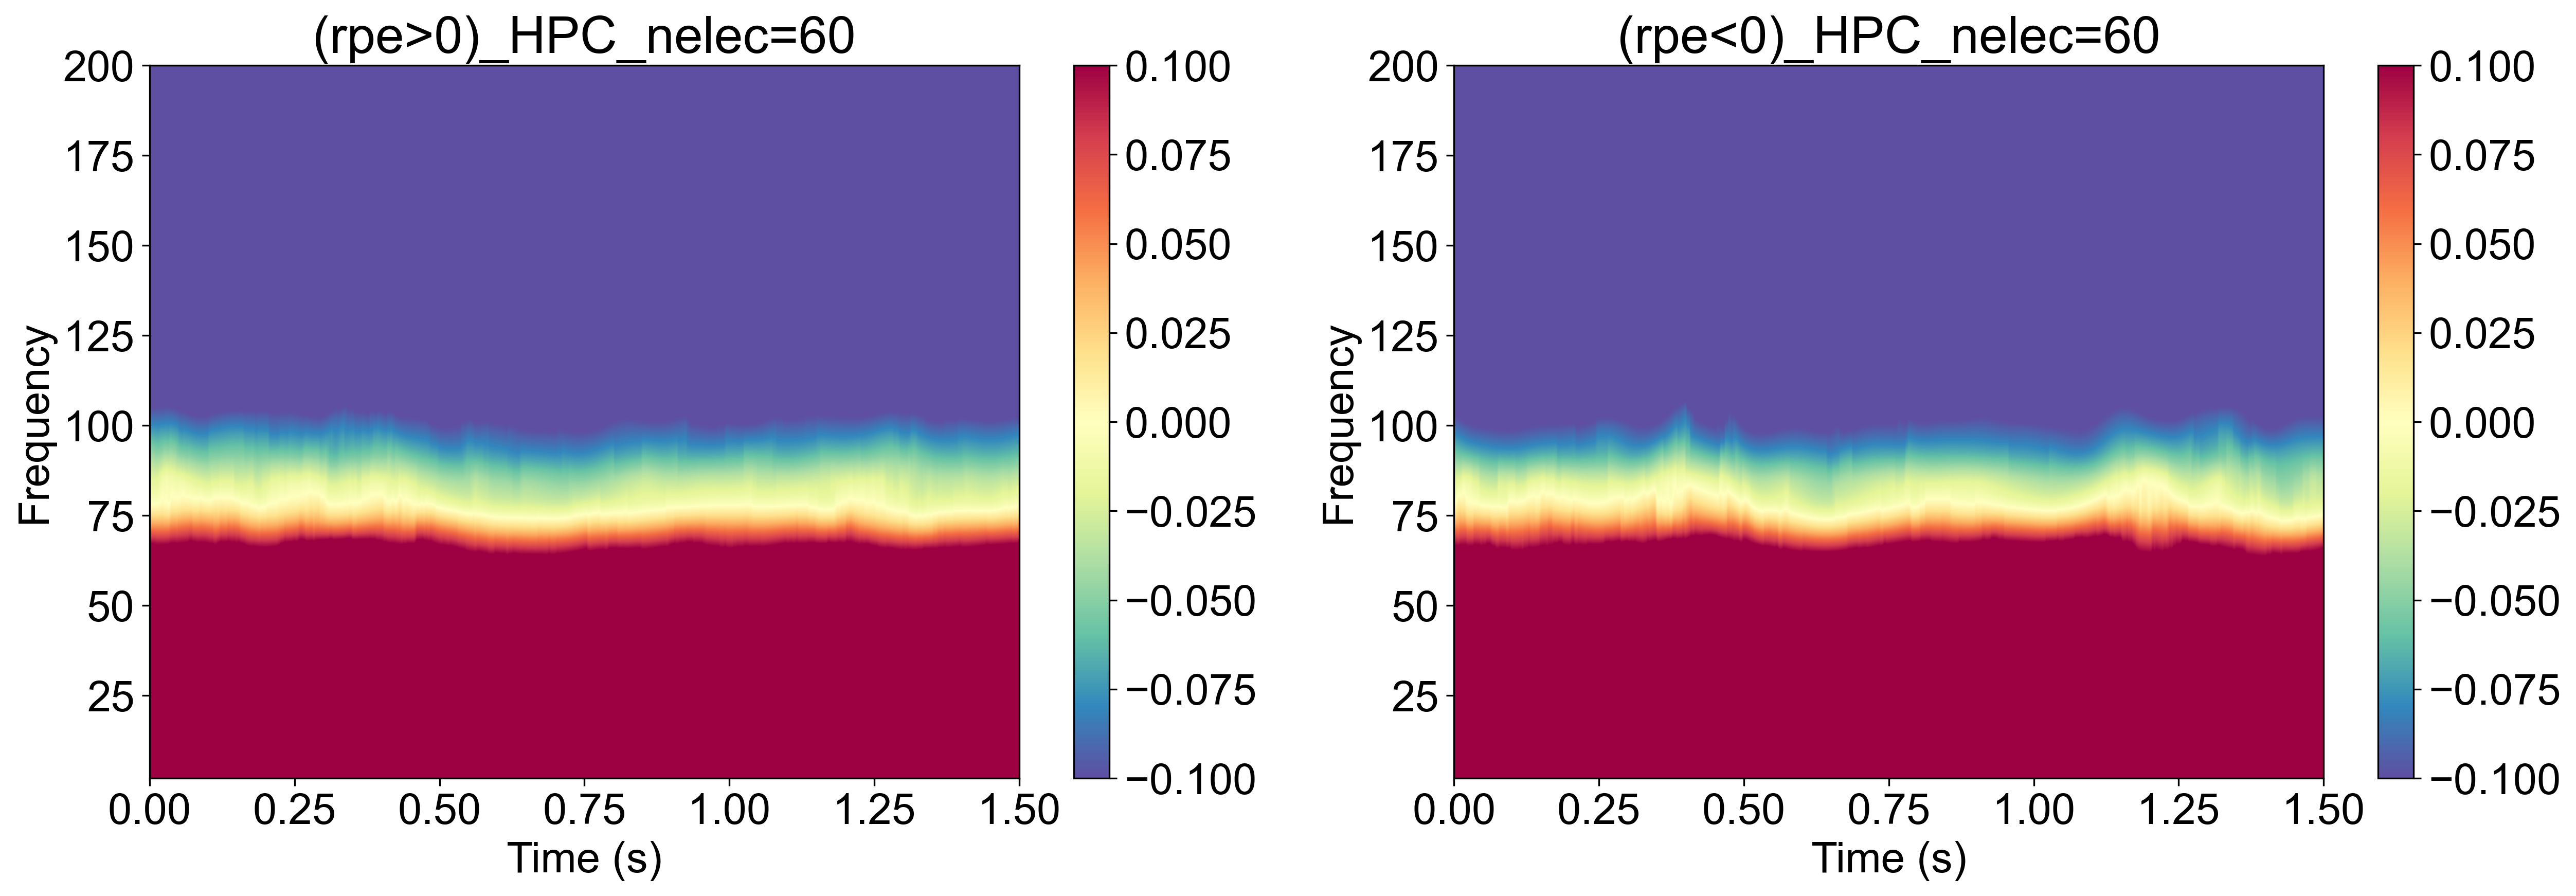

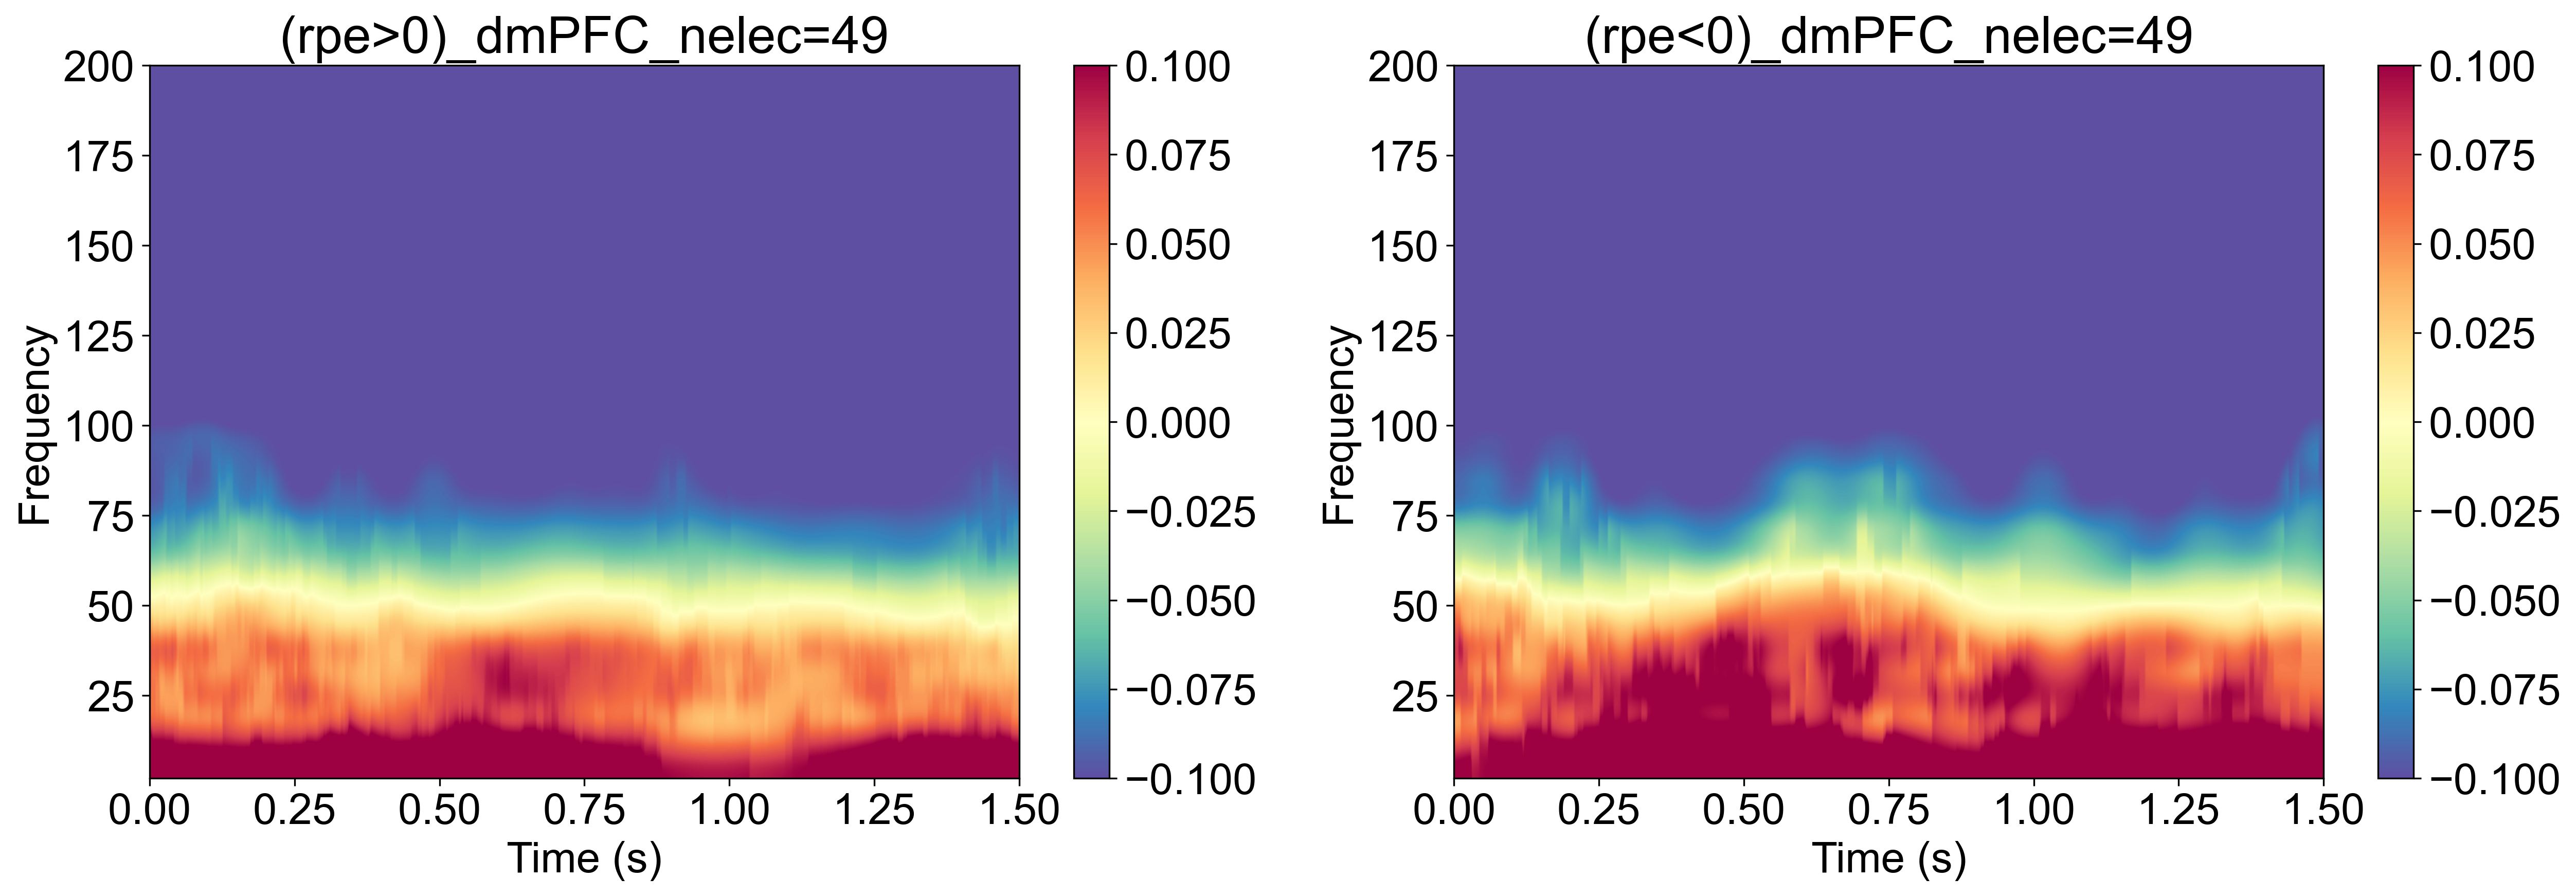

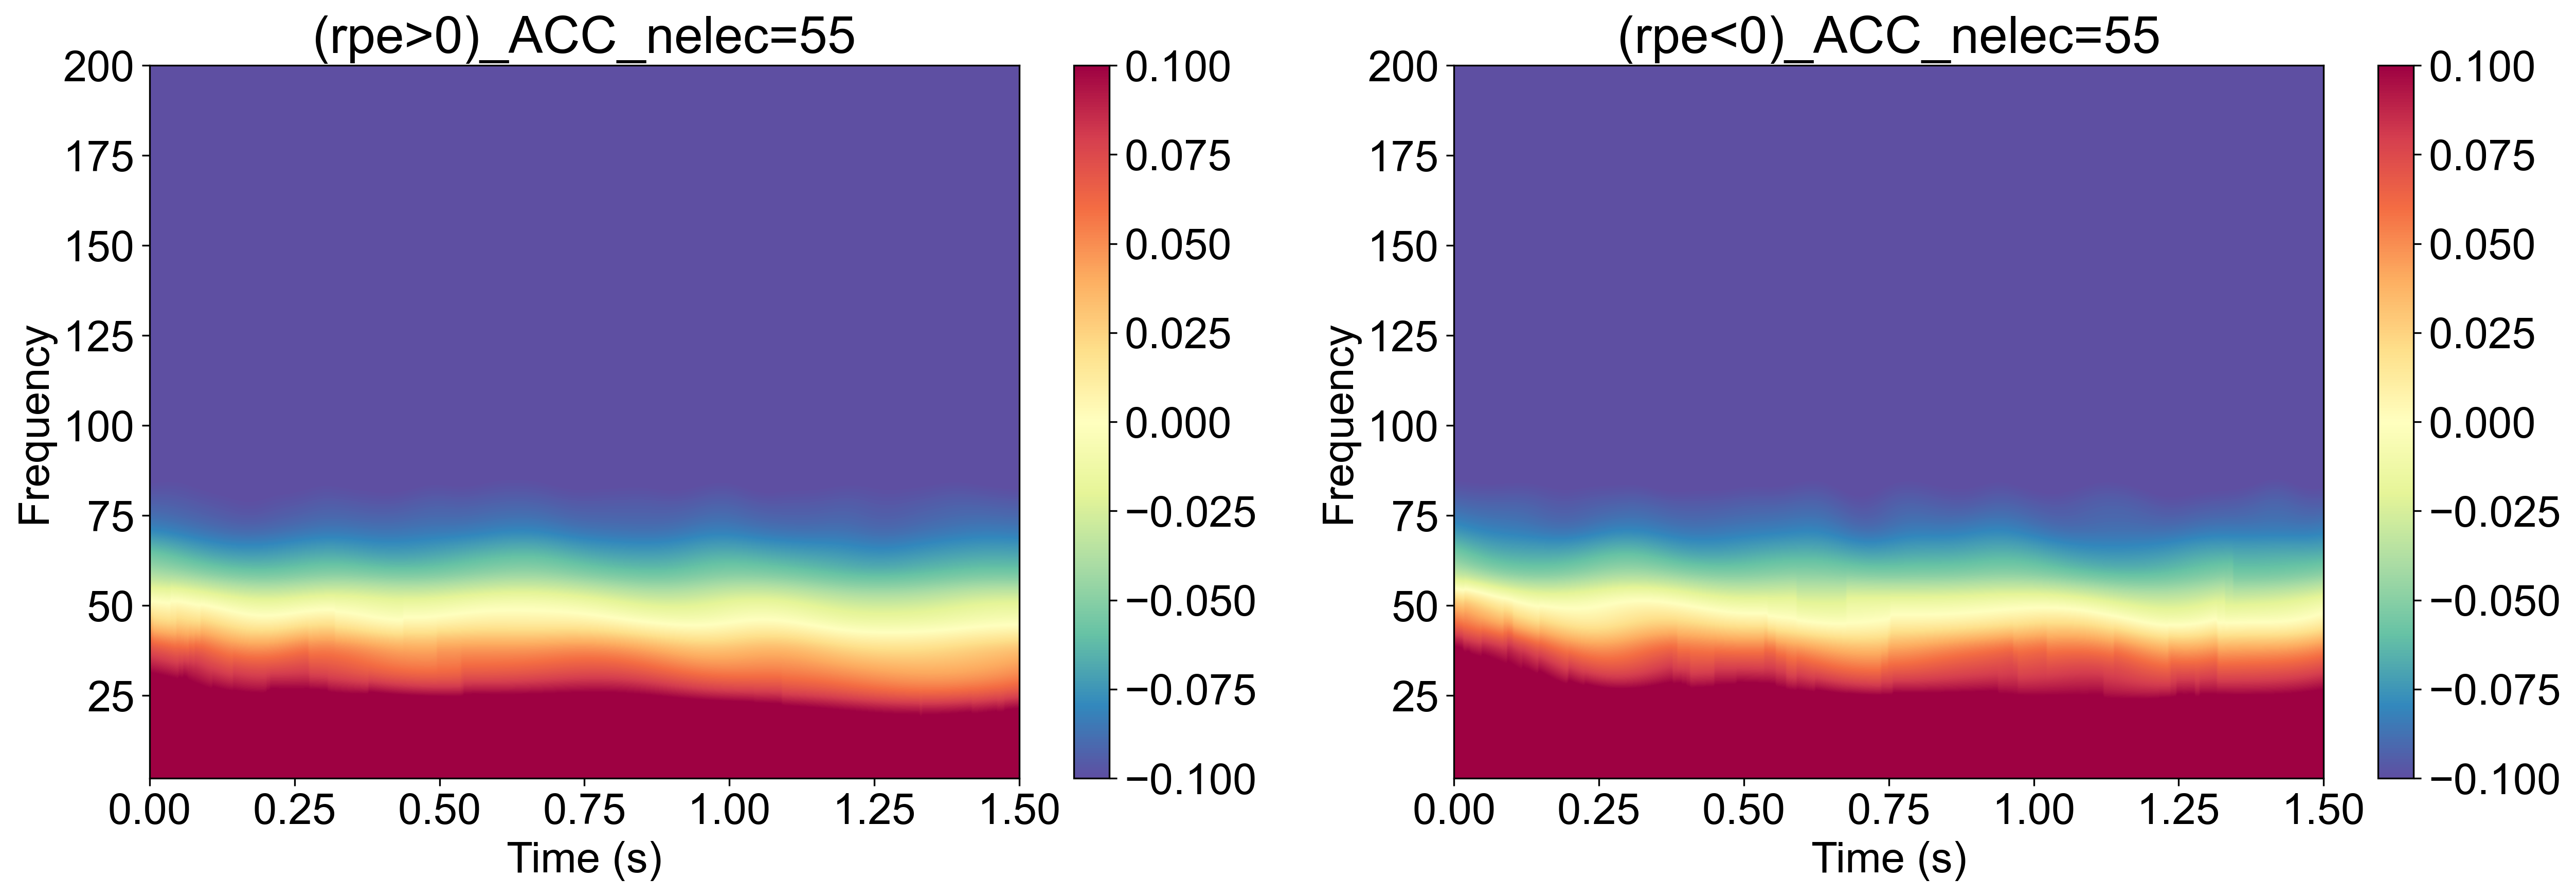

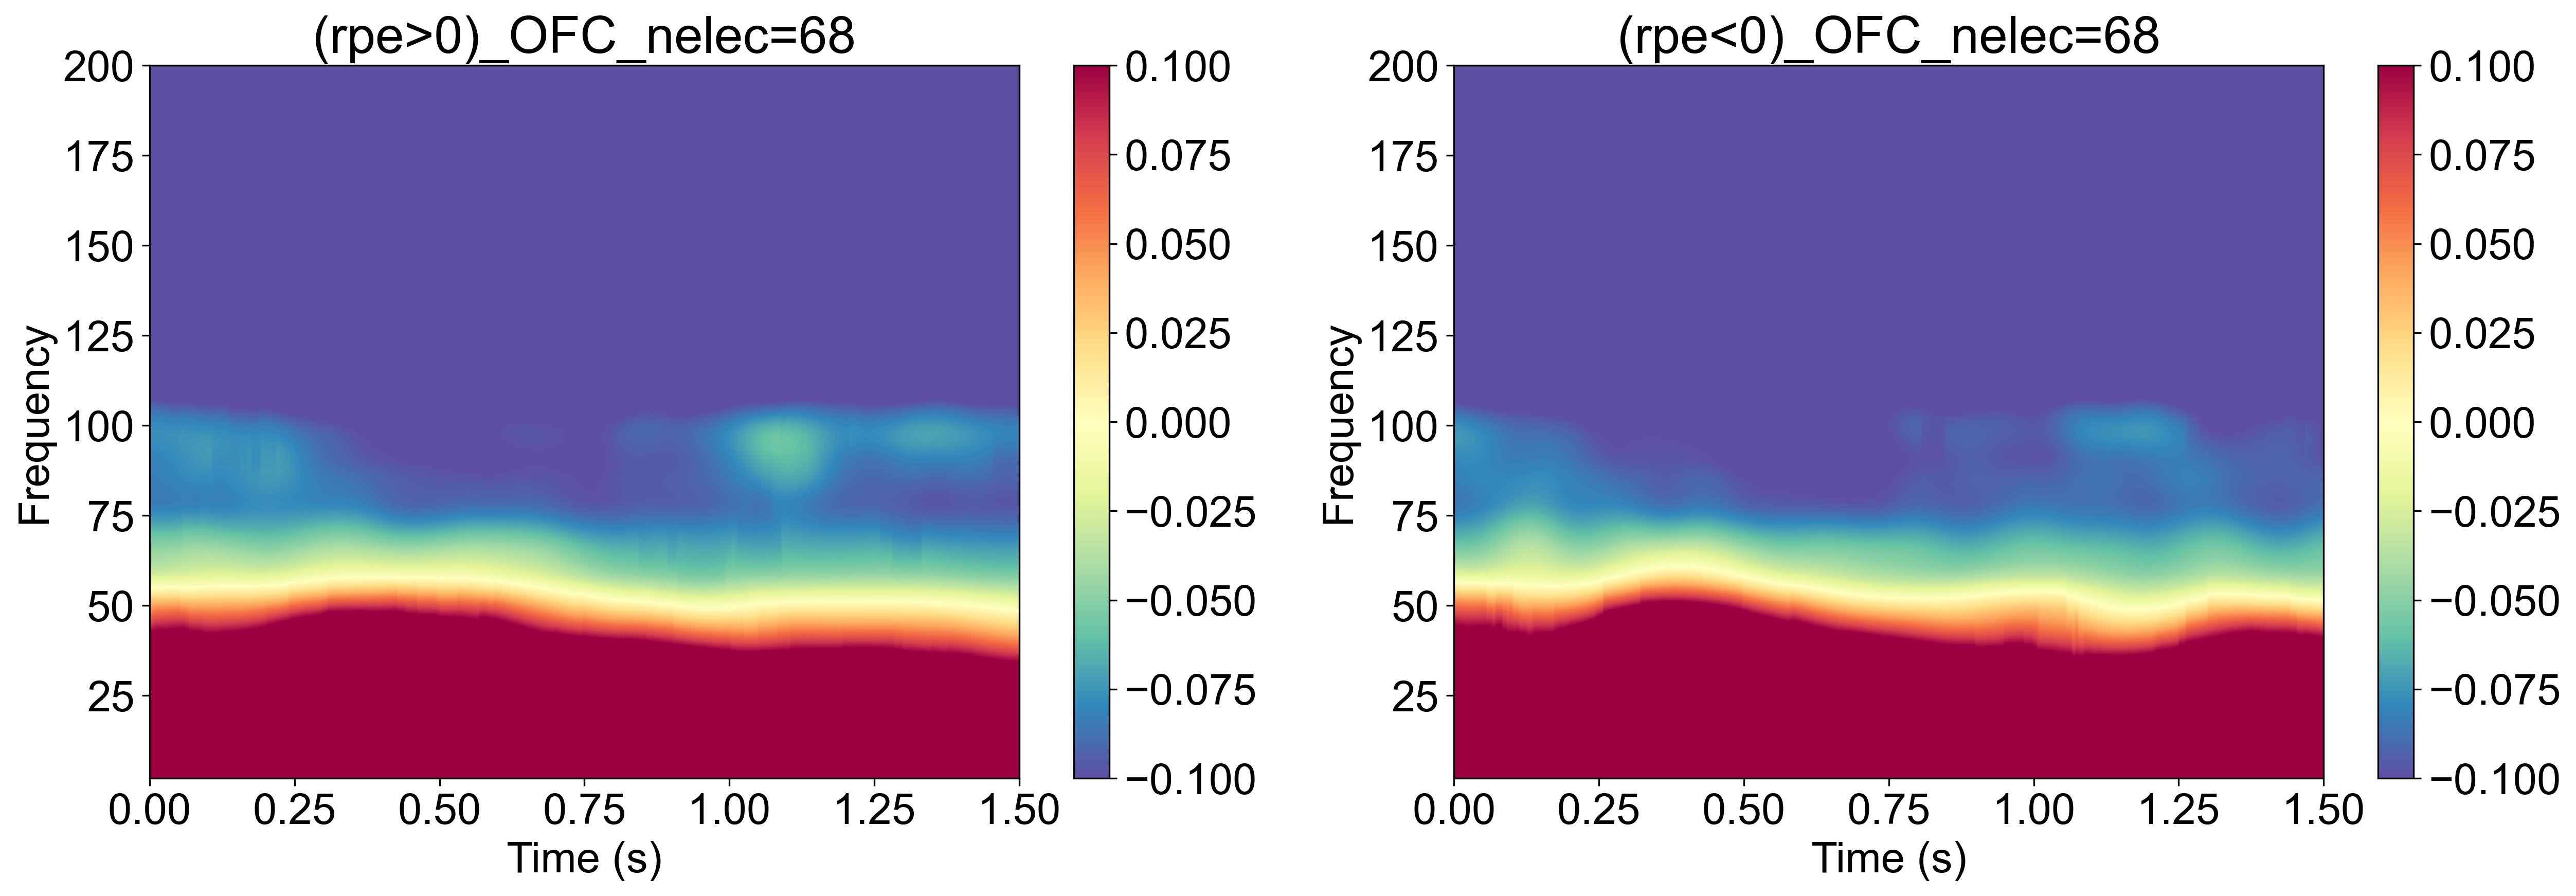

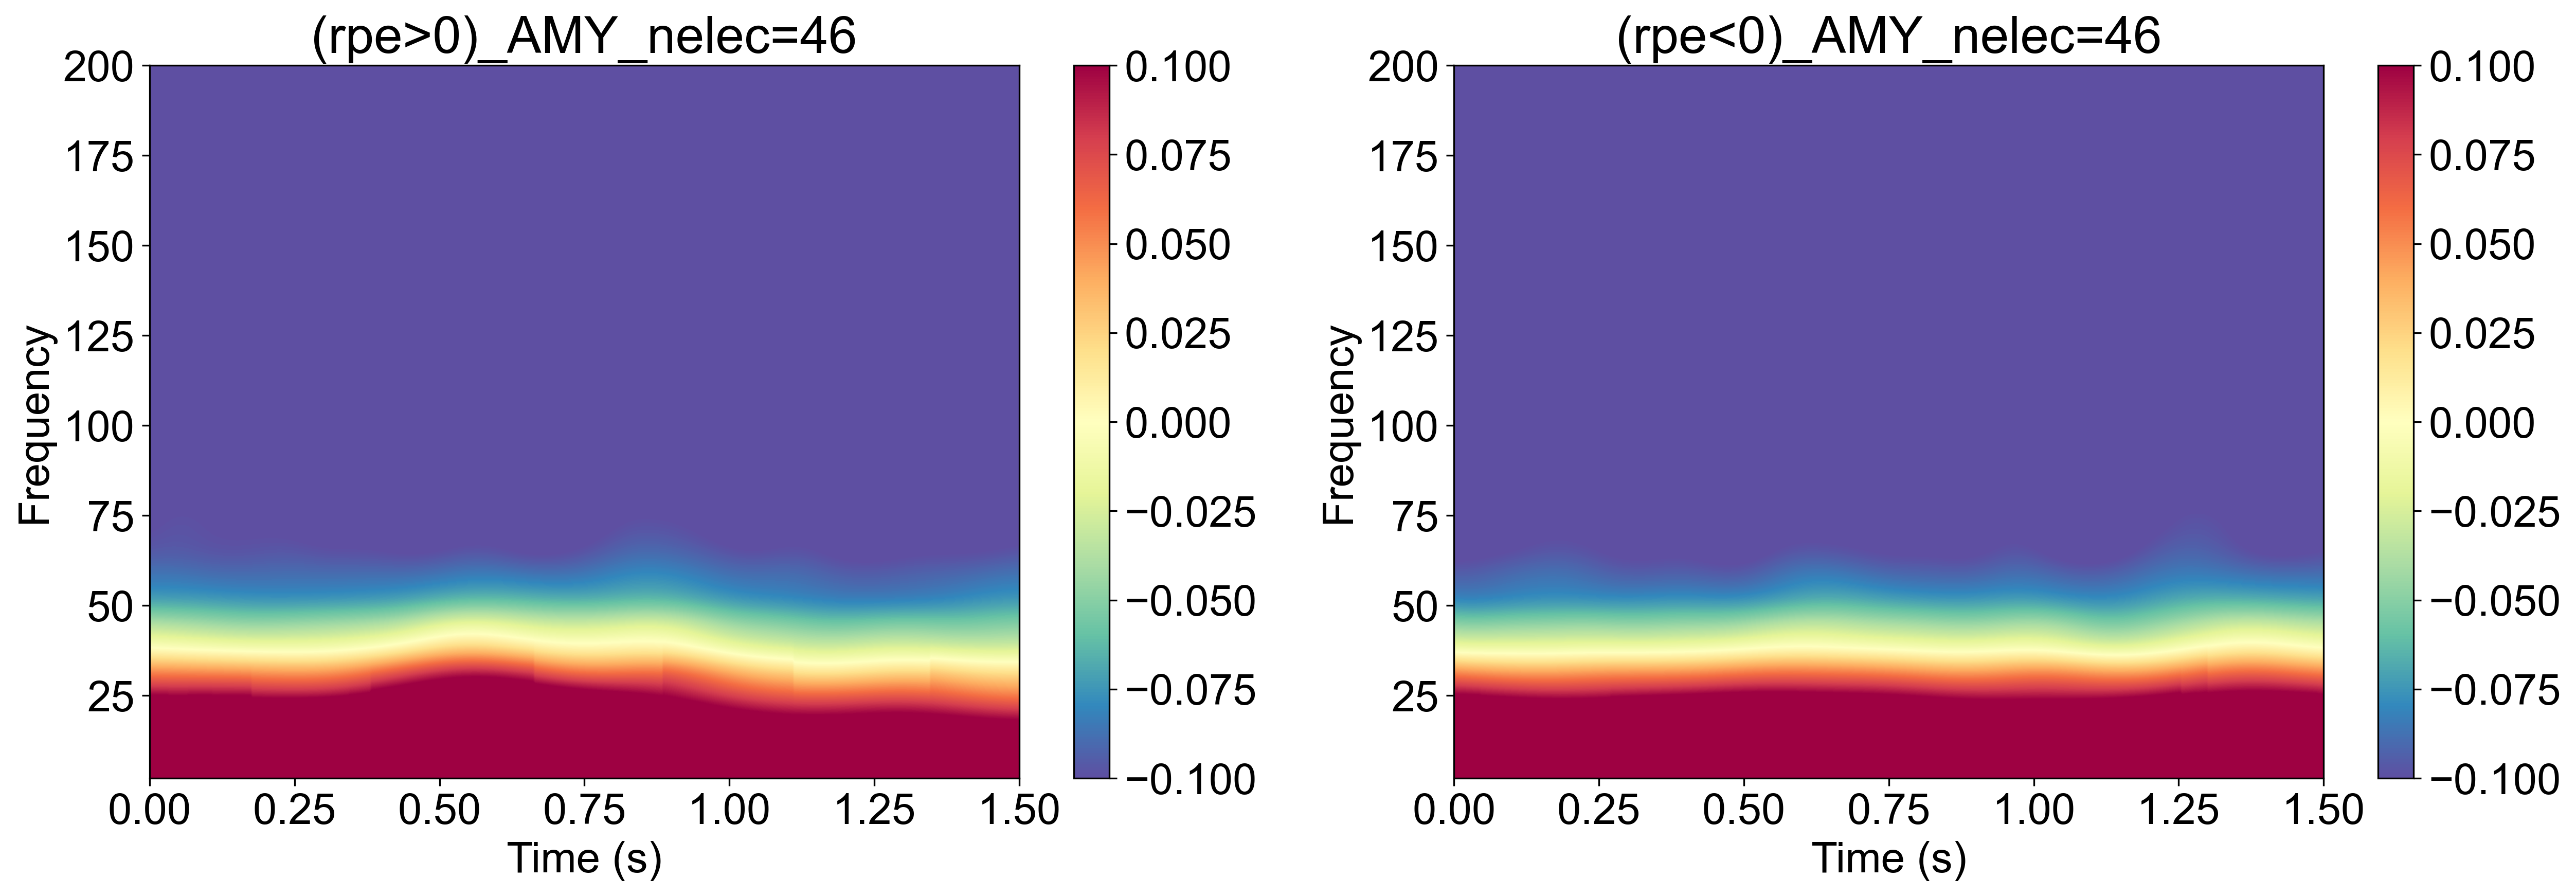

In [127]:
freqs = np.logspace(*np.log10([2, 200]), num=30)

for region in rois: 
    # if region == 'TC':
    #     region = (('Temporal') | ('Temporal Pole') | ('STS'))
    fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
    for ix, cond in enumerate(conditions): 
        # Set the times for 
        n_elecs = np.squeeze(np.stack(tfr_group_data[region][cond])).shape[0]
        times = np.linspace(0, 1.5, np.squeeze(np.stack(tfr_group_data[region][cond])).shape[2])

#         if cond_name == 'SME':
#             plot_data = np.nanmedian(np.nanmedian(np.squeeze(np.stack(tfr_group_data[region][cond])), axis=0), axis=0)
#         else:
        plot_data = np.nanmean(np.squeeze(np.stack(tfr_group_data[region][cond])), axis=0)
        if region in ['AINS']:
            im = ax[ix].imshow(plot_data,
                      extent=[times[0], times[-1], freqs[0], freqs[-1]],
                      aspect='auto', origin='lower', cmap='Spectral_r', vmin =-0.5, vmax =0.5, interpolation = 'bicubic')
        else:
            im = ax[ix].imshow(plot_data,
                      extent=[times[0], times[-1], freqs[0], freqs[-1]],
                      aspect='auto', origin='lower', cmap='Spectral_r', vmin =-0.1, vmax =0.1, interpolation = 'bicubic')            
        ax[ix].set(xlabel='Time (s)', ylabel='Frequency', title=f'{cond}_{region}_nelec={n_elecs}')
        fig.colorbar(im, ax=ax[ix])
        plt.savefig(f'/sc/arion/work/qasims01/MemoryBanditData/EMU/plots/feedback_TFR_{cond_name}_{region}.pdf', dpi=300)

        
        

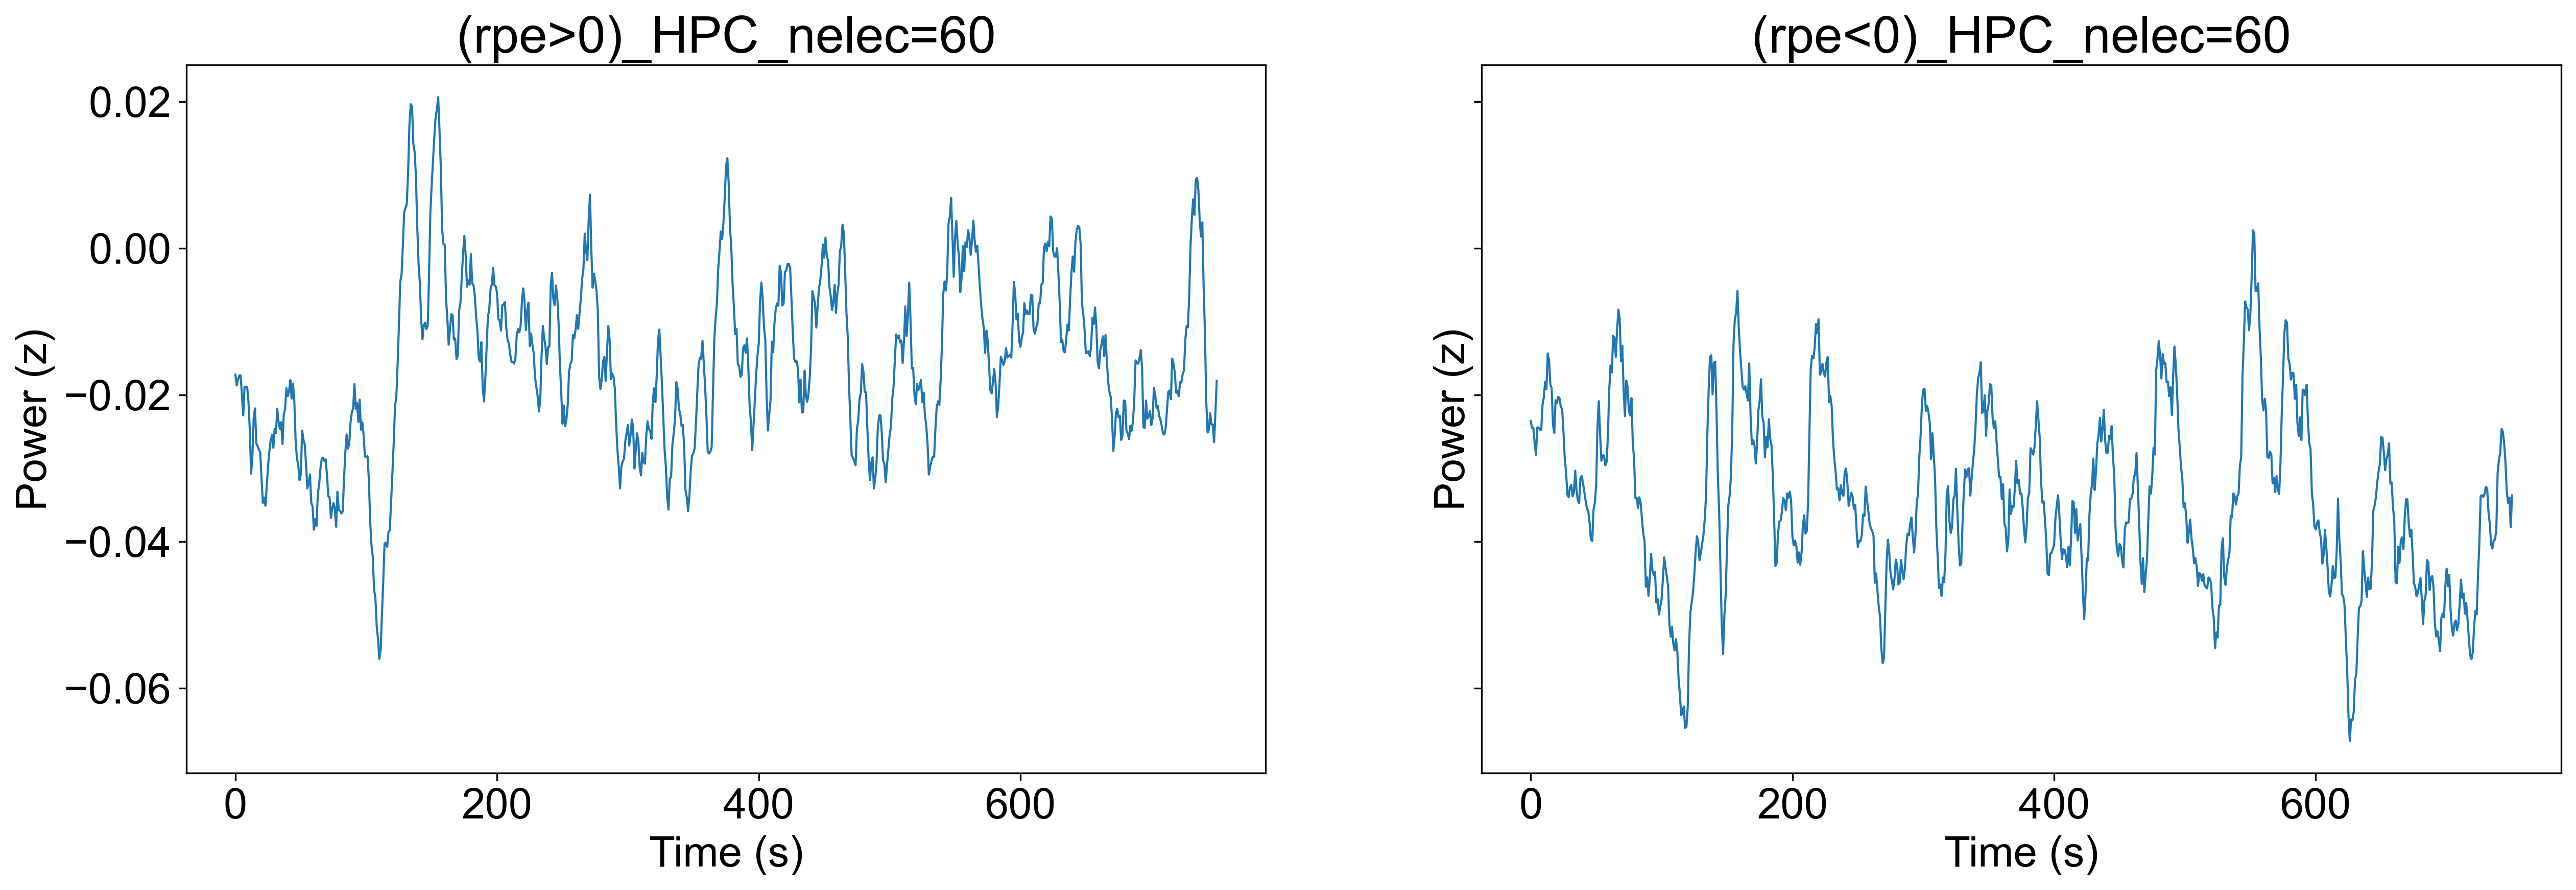

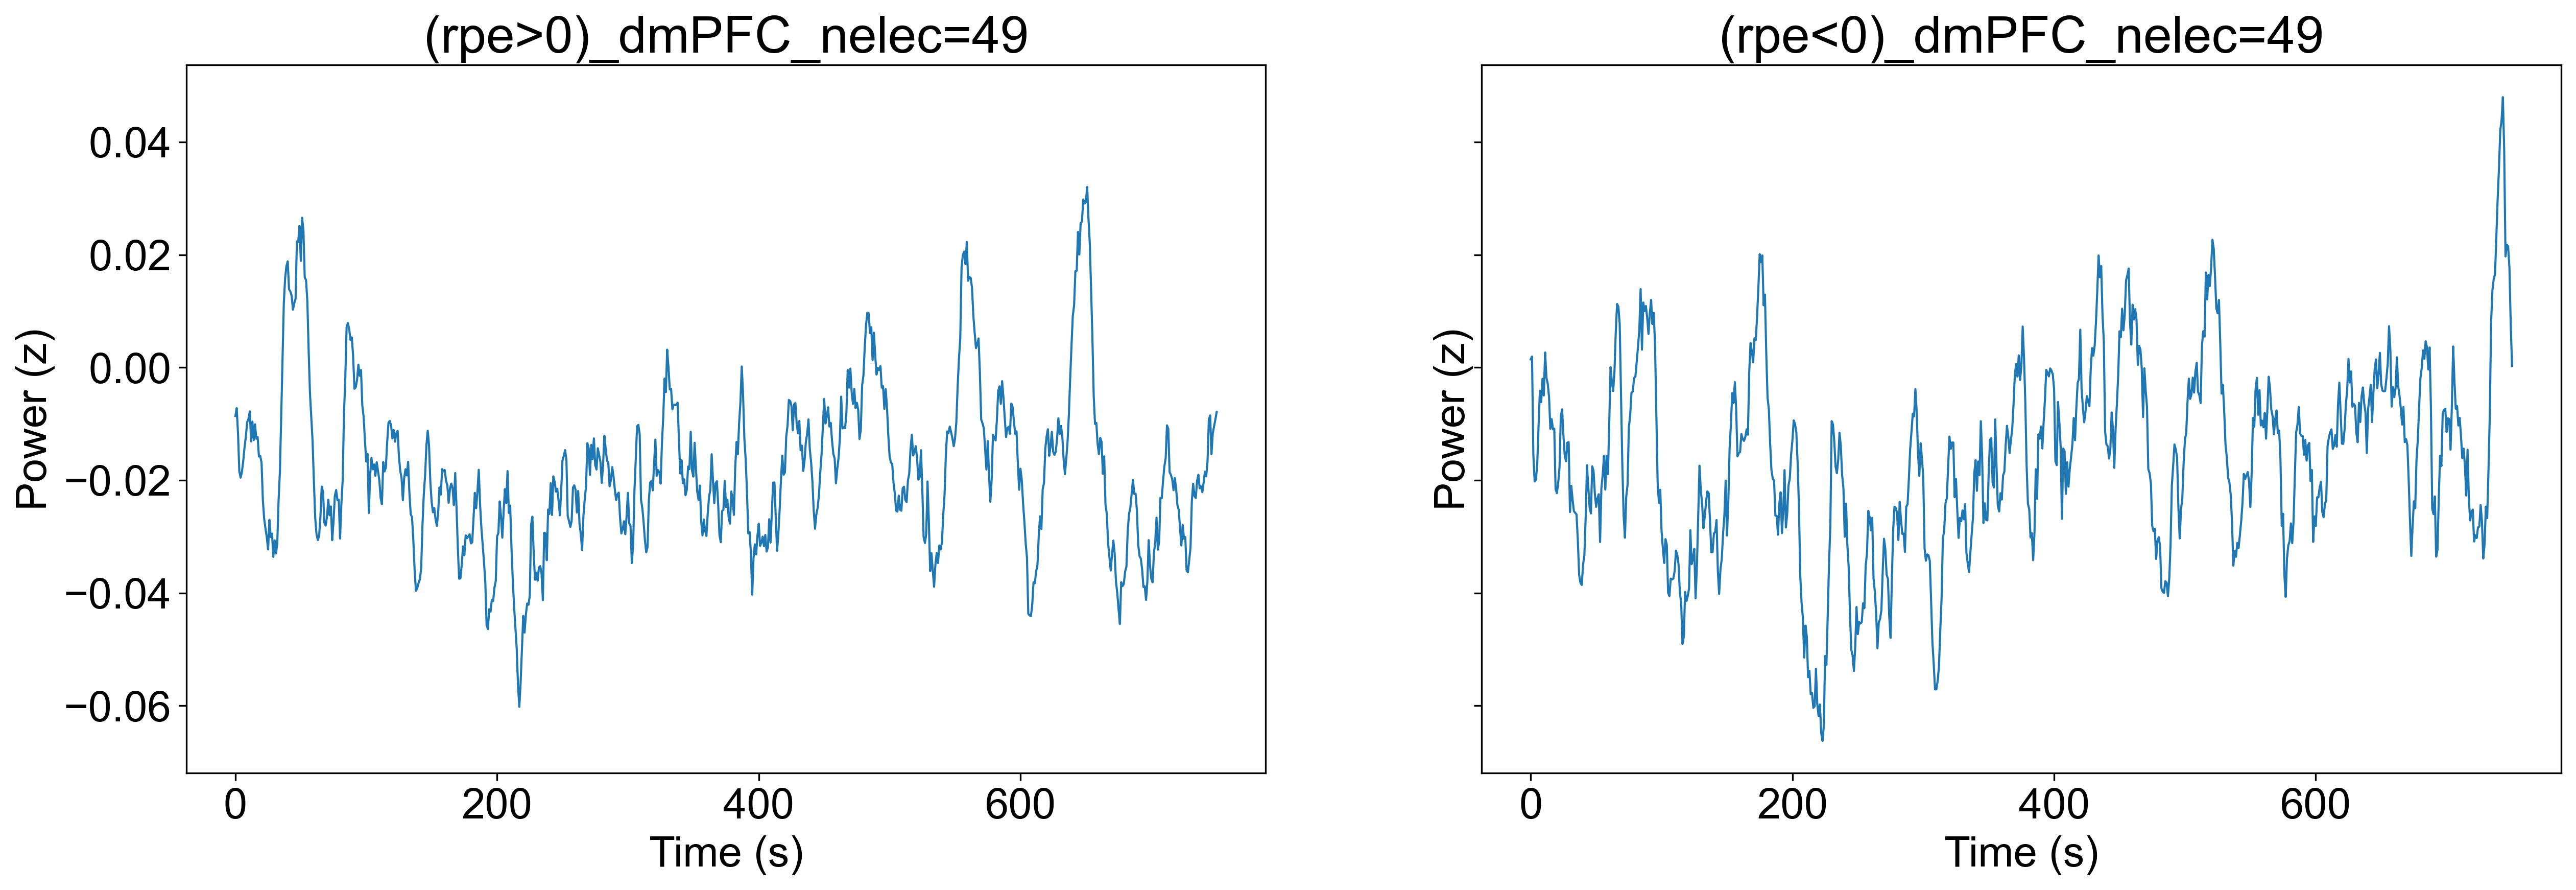

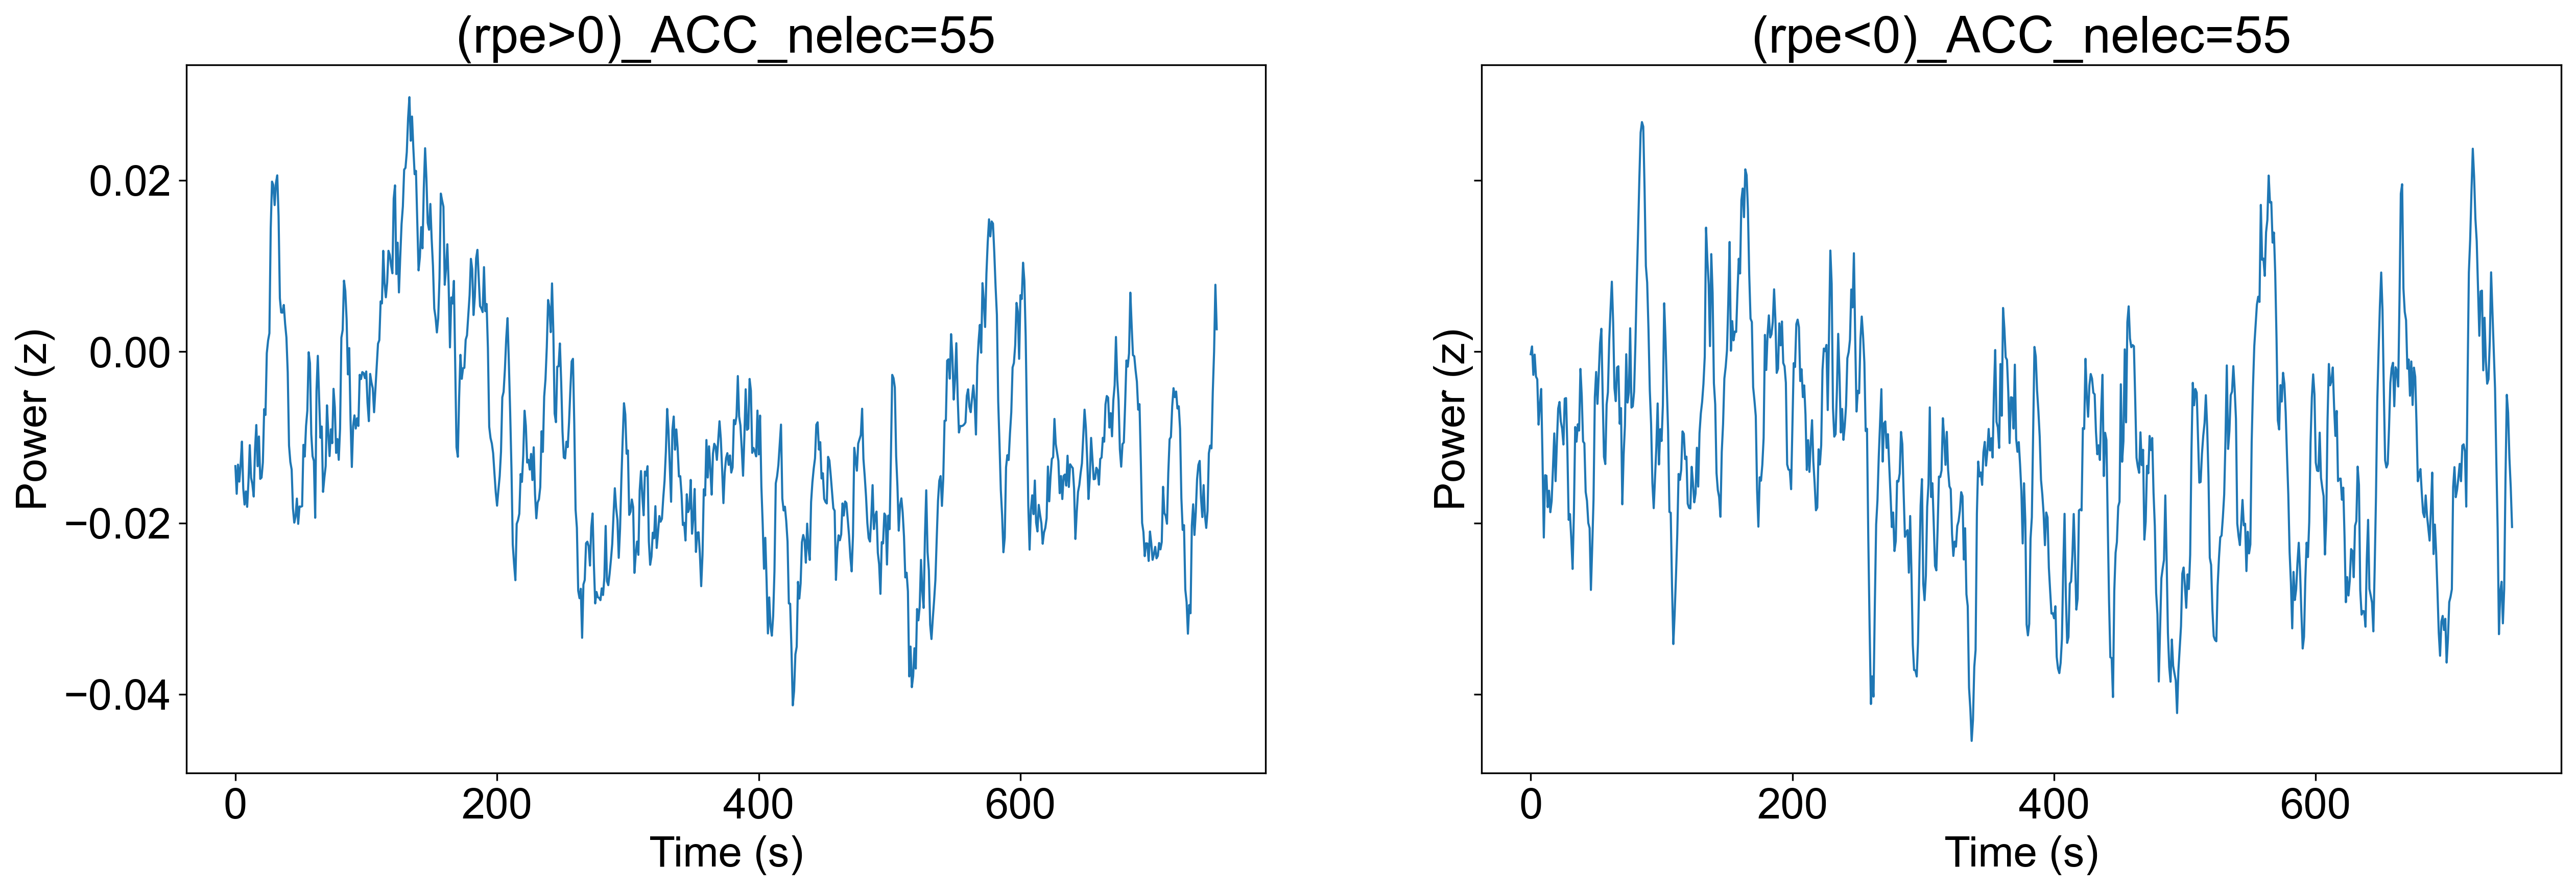

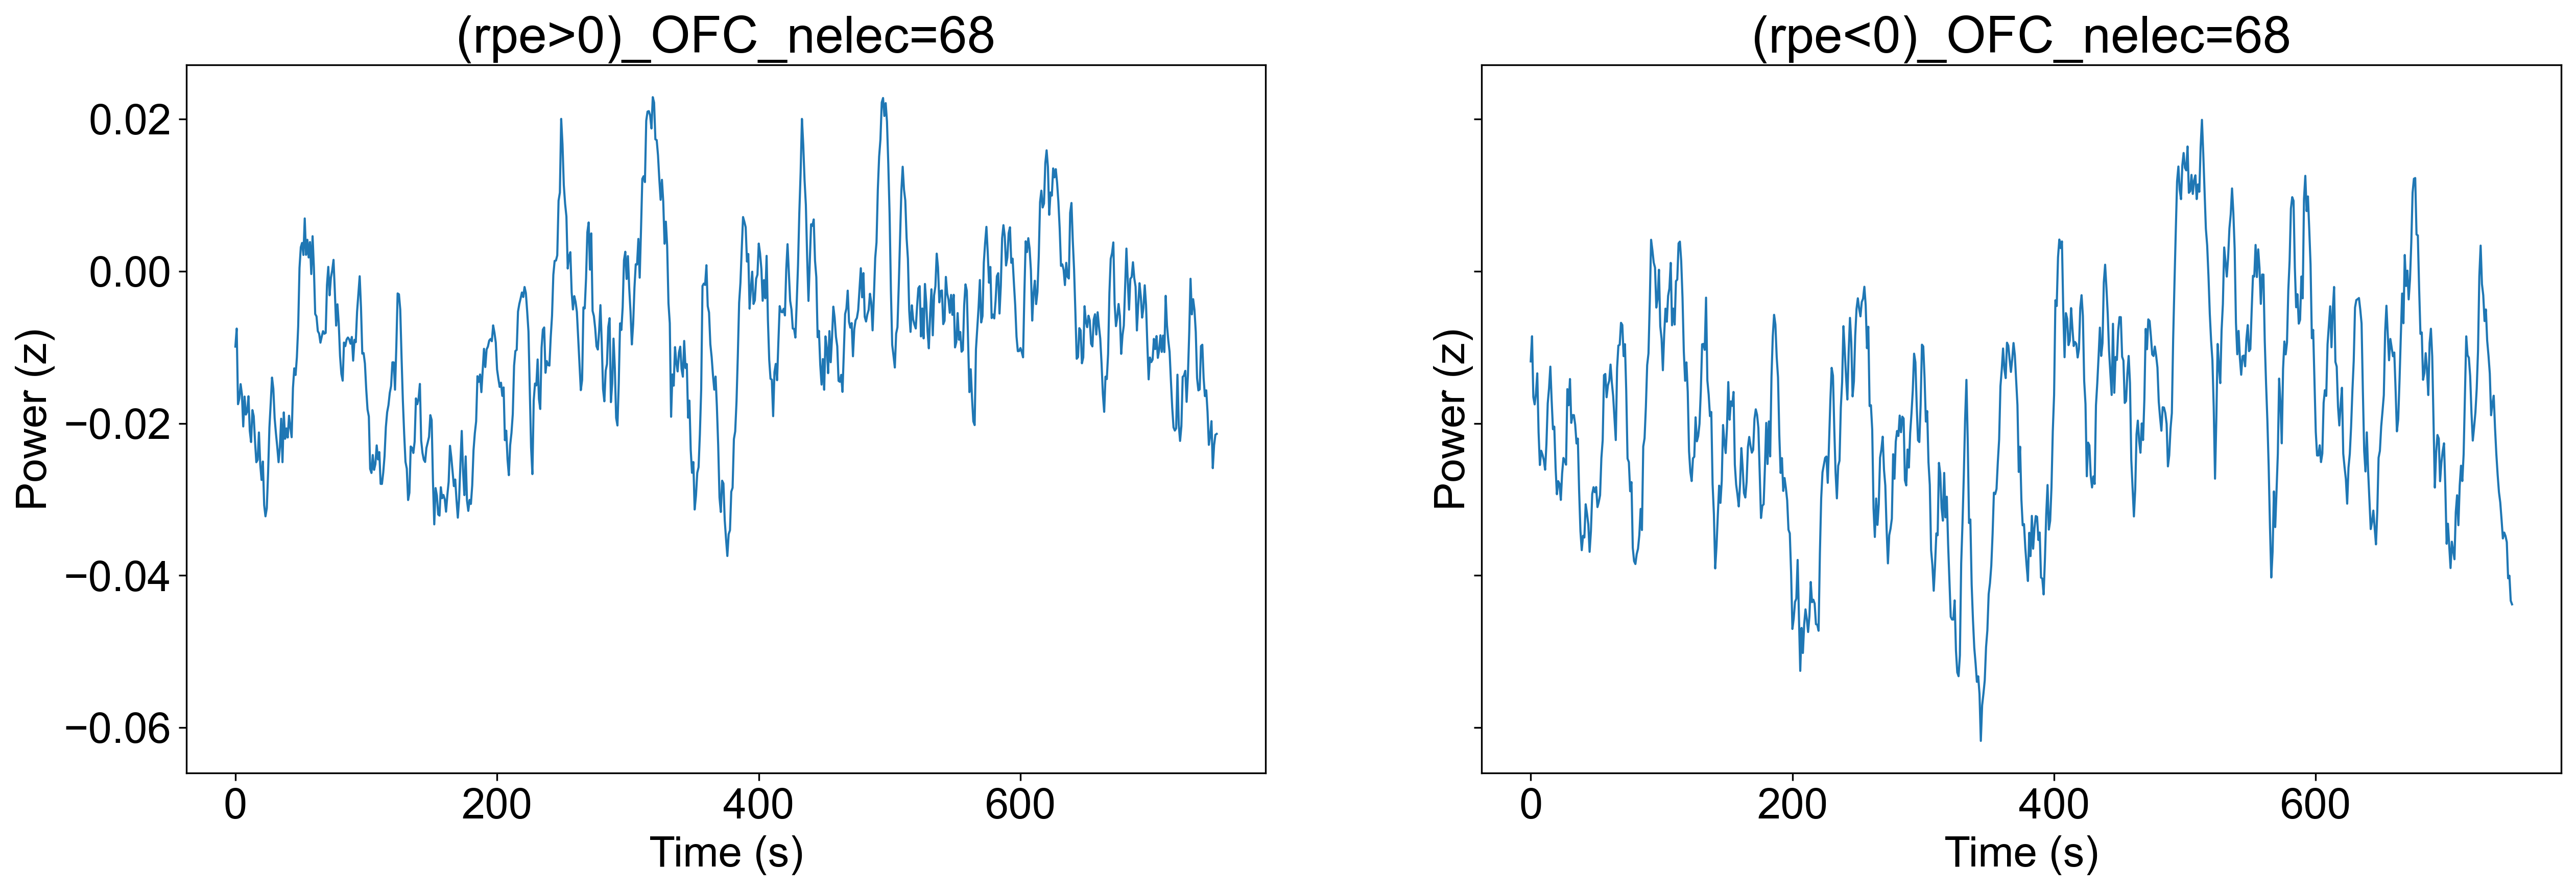

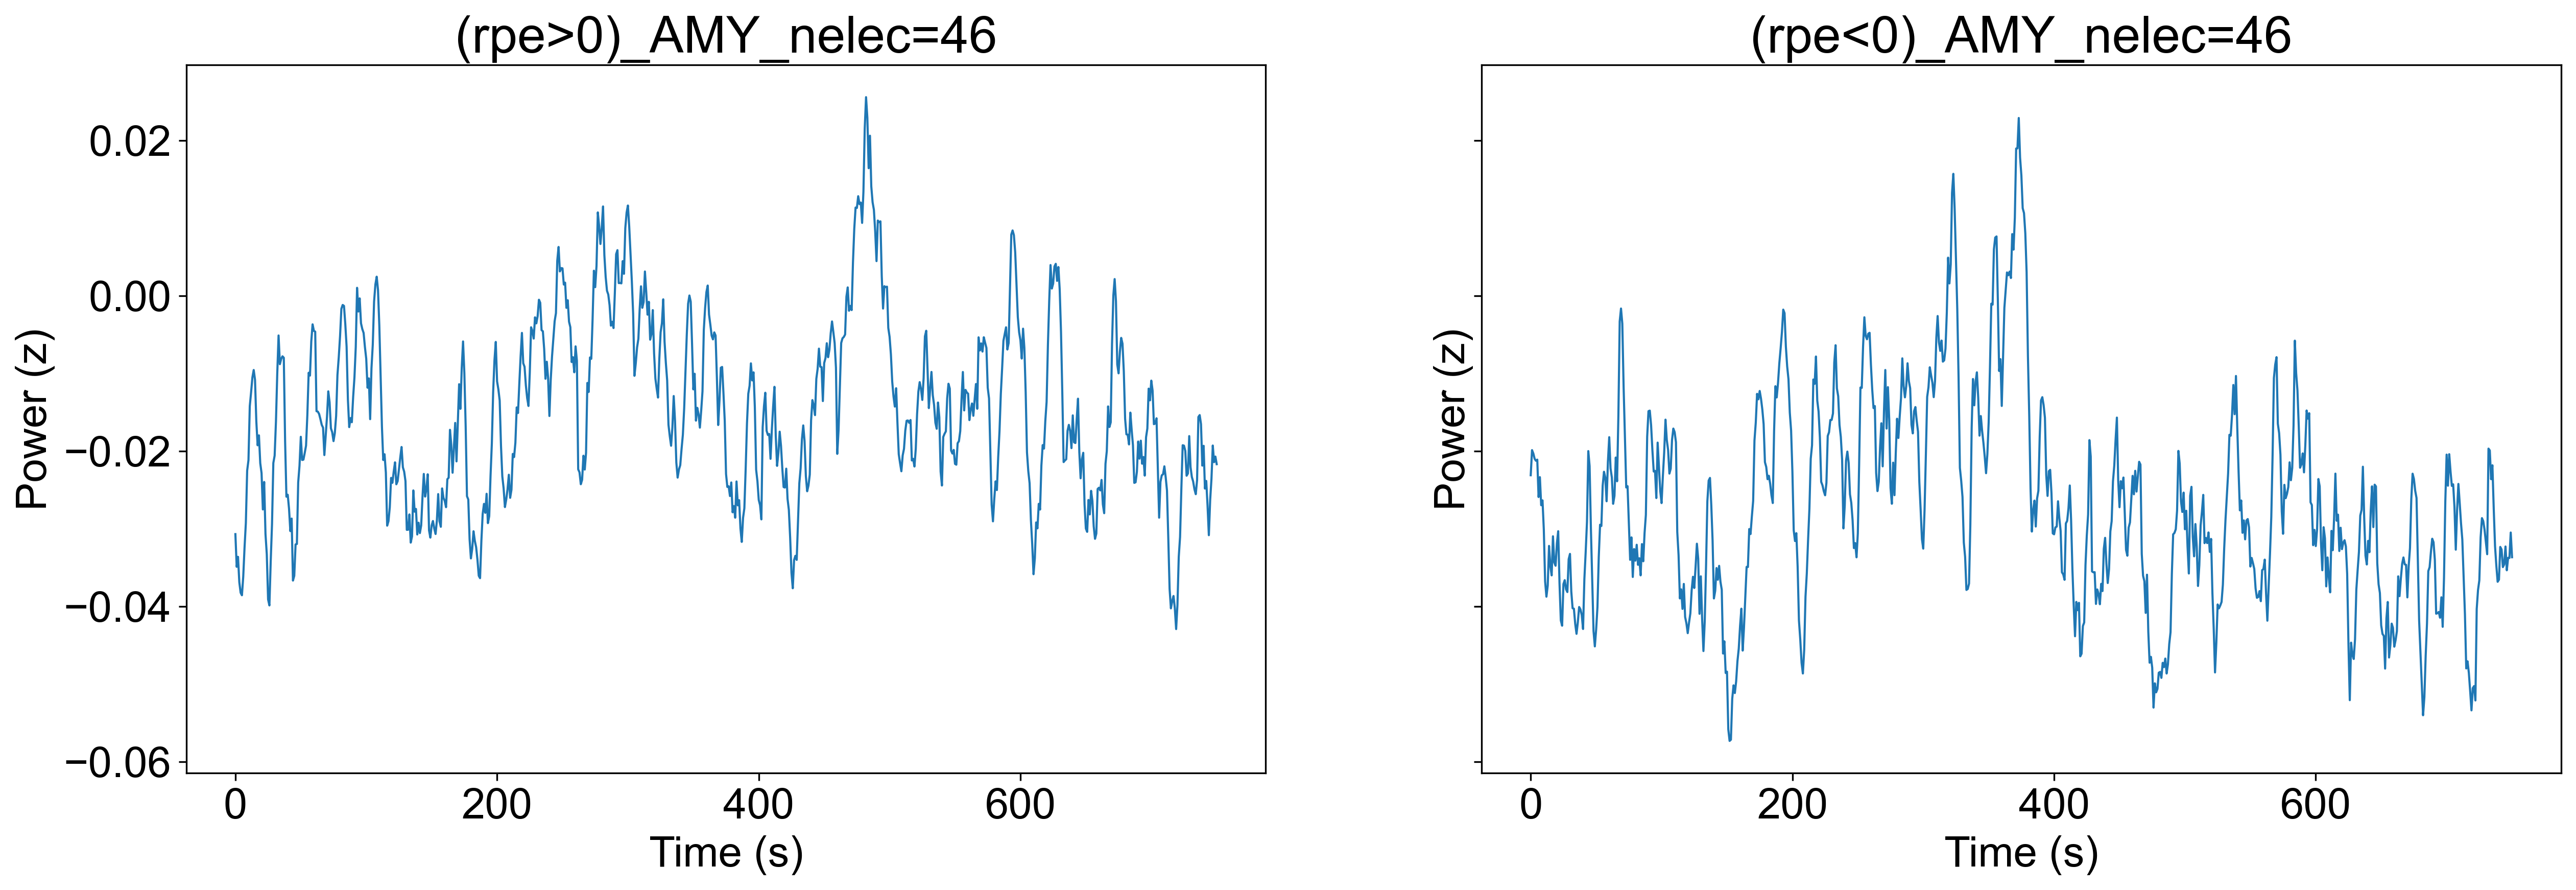

In [41]:
for region in rois: 
    # if region == 'TC':
    #     region = (('Temporal') | ('Temporal Pole') | ('STS'))
    fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=300, sharey=True, sharex=True)
    for ix, cond in enumerate(conditions): 
        # Set the times for 
        n_elecs = np.squeeze(np.stack(tfr_group_data[region][cond])).shape[0]
        times = np.linspace(0, 1.5, np.squeeze(np.stack(tfr_group_data[region][cond])).shape[2])

#         if cond_name == 'SME':
#             plot_data = np.nanmedian(np.nanmedian(np.squeeze(np.stack(tfr_group_data[region][cond])), axis=0), axis=0)
#         else:
        plot_data = np.nanmedian(np.squeeze(np.stack(tfr_group_data[region][cond])), axis=0)
        if region in ['AINS']:
            im = ax[ix].imshow(plot_data,
                      extent=[times[0], times[-1], freqs[0], freqs[-1]],
                      aspect='auto', origin='lower', cmap='Spectral_r', vmin =-0.5, vmax =0.5, interpolation = 'bicubic')
        else:
            ax[ix].plot(np.nanmean(plot_data[freqs>55, :], axis=0))
            # im = ax[ix].imshow(plot_data,
            #           extent=[times[0], times[-1], freqs[0], freqs[-1]],
            #           aspect='auto', origin='lower', cmap='Spectral_r', vmin =-0.1, vmax =0.1, interpolation = 'bicubic')            
        ax[ix].set(xlabel='Time (s)', ylabel='Power (z)', title=f'{cond}_{region}_nelec={n_elecs}')
        # fig.colorbar(im, ax=ax[ix])
        plt.savefig(f'/sc/arion/work/qasims01/MemoryBanditData/EMU/plots/feedback_HFA_{cond_name}_{region}.pdf', dpi=300)


Conduct the two-sample permutation test. This is most handy if your categories are naturally discrete, or helpful to bin. It is less good if you woud actually get statistical value from continuous stats.

stat_fun(H1): min=0.022323 max=94.908034
Running initial clustering …
Found 6 clusters


  0%|          | Permuting : 0/999 [00:00<?,       ?it/s]

TypeError: Invalid shape (751,) for image data

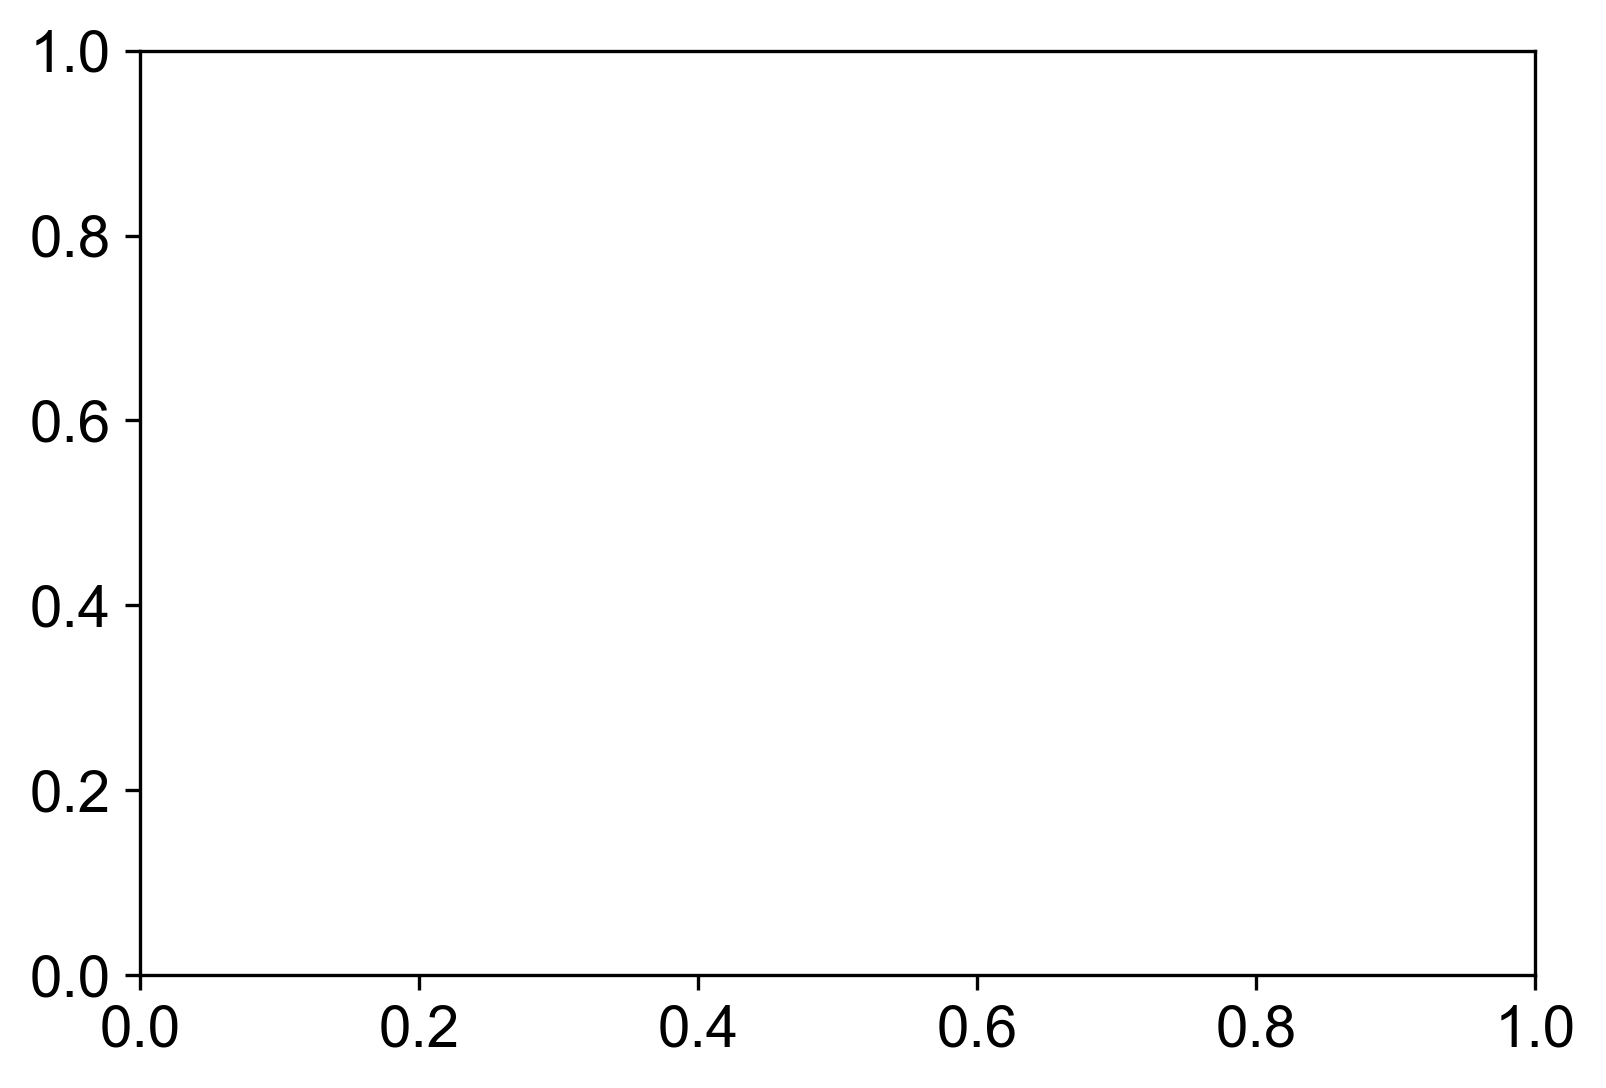

In [66]:
# freqs = np.logspace(*np.log10([4, 120]), num=30)

# conditions = ['(rpe>0)',
#              '(rpe<0)']
# conditions = ['(rpe>0) & (hits==1)',
#              '(rpe>0) & (hits==0)']

cond_name = 'SME'
        
# times = np.linspace(0, 1.5, np.stack(tfr_group_data[region][cond]).shape[2])
    
for region in rois: 
    # # Average the data in each condition across channels 
    if 'SME' in cond_name:
        X = [np.squeeze(np.vstack(tfr_group_data[region][conditions[0]])),
             np.squeeze(np.vstack(tfr_group_data[region][conditions[1]]))]
    else:
        X = [np.stack(tfr_group_data[region][conditions[0]]), 
             np.stack(tfr_group_data[region][conditions[1]])]
        
    F_obs, clusters, cluster_p_values, H0 = \
mne.stats.permutation_cluster_test(X, n_permutations=1000, out_type='mask', verbose=True,
                                   threshold=6,
                                   seed=1, n_jobs=1, tail=0)
    
    # Create new stats image with only significant clusters
    fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    
    # Average the data in each condition across epochs for plotting
    evoked_power_1 = np.nanmean(X[0], axis=0)
    evoked_power_2 = np.nanmean(X[1], axis=0)
    evoked_power_contrast = evoked_power_1 - evoked_power_2
    signs = np.sign(evoked_power_contrast)

    F_obs_plot = np.nan * np.ones_like(F_obs)
    for c, p_val in zip(clusters, cluster_p_values):
        if p_val <= 0.05:
            F_obs_plot[c] = F_obs[c] * signs[c]

    ax.imshow(F_obs,
              extent=[times[0], times[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='Spectral_r', alpha =0.55)
    max_F = np.nanmax(abs(F_obs_plot))
    c= ax.imshow(F_obs_plot,
              extent=[times[0], times[-1], freqs[0], freqs[-1]],
              aspect='auto', origin='lower', cmap='Spectral_r',
              vmin=-max_F, vmax=max_F)

    ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{region}_{cond_name}')
    fig.colorbar(c, ax=ax)
    plt.savefig(f'/sc/arion/work/qasims01/MemoryBanditData/EMU/plots/feedback_clustperm_{cond_name}_{region}.pdf', dpi=300)


## Memory TFRs contrast RPEs

In [4]:
# # Let's load the power epochs: 

# analysis_evs = ['recog_time']

# # band definitions for y-axis
# yticks = [4, 8, 13, 30, 60, 120]

# # task condition to contrast 
# conditions = ['(rpe<0)&(hits==True)',
#              '(rpe<0)&(hits==False)']

# cond_name = 'nrpe_memory'

# tfr_group_data = {f'{a}': {f'{b}': [] for b in conditions} for a in rois}

# power_epochs = {f'{a}': {f'{b}': {f'{c}': np.nan for c in days} for b in analysis_evs} for a in subj_ids}

# for subj_ix, subj_id in enumerate(subj_ids):
#     for day in ['Day1']: 
#         if (day=='Day2') & (subj_days[subj_ix]==0):
#             continue
#         else:
#             for event in analysis_evs:
#                 filepath = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/scratch/TFR'
#                 power_epochs[subj_id][event][day] = mne.time_frequency.read_tfrs(f'{filepath}/{event}_{day}-tfr.h5')[0]

#                 power_epochs[subj_id][event][day].metadata = combined_df[(combined_df.participant==subj_id) & (combined_df.condition==day)]

#                 # Get electrode df 
#                 elec_df = pd.read_csv(f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}/Day1_reref_elec_df')

#                 progress_bar = tqdm(elec_df.label, ascii=True, desc='Aggregating TFRs')

#                 for elec_ix, chan in enumerate(progress_bar):
#                     region = elec_df.salman_region.iloc[elec_ix]
#                     if region in rois:
#                         for ix, cond in enumerate(conditions):
#                             # Set the times for 
#                             times = power_epochs[subj_id][event][day].times
#                             plot_data = power_epochs[subj_id][event][day][cond].pick_channels([chan]).data
#                             tfr_group_data[region][cond].append(plot_data)                    


In [6]:
# freqs = np.logspace(*np.log10([4, 120]), num=30)

# for region in rois: 
#     fig, ax = plt.subplots(1, 2, figsize=(20, 6), dpi=300)
#     for ix, cond in enumerate(conditions): 
#         # Set the times for 
#         n_elecs = np.squeeze(np.vstack(tfr_group_data[region][cond])).shape[0]
#         # times = np.linspace(0, 1.5, np.squeeze(np.vstack(tfr_group_data[region][cond])).shape[2])

#         plot_data = np.nanmean(np.squeeze(np.vstack(tfr_group_data[region][cond])), axis=0)
#         im = ax[ix].imshow(plot_data,
#                   extent=[times[0], times[-1], freqs[0], freqs[-1]],
#                   aspect='auto', origin='lower', cmap='Spectral_r', 
#                            vmin =-0.1, vmax =0.1, interpolation = 'bicubic')
#         ax[ix].set(yticks=yticks, xlabel='Time (s)', 
#                    ylabel='Frequency', title=f'{cond}_{region}_nelec={n_elecs}')
#         fig.colorbar(im, ax=ax[ix])
#         plt.savefig(f'/sc/arion/work/qasims01/MemoryBanditData/EMU/plots/recog_time_TFR_{cond_name}_{region}.pdf', 
#                     dpi=300)

        
        

In [7]:
# freqs = np.logspace(*np.log10([4, 120]), num=30)

# cond_name = 'nrpe_memory'
        
# # times = np.linspace(0, 1.5, np.stack(tfr_group_data[region][cond]).shape[2])
    
# for region in rois: 
#     # # Average the data in each condition across channels 
#     if 'memory' in cond_name:
#         X = [np.squeeze(np.vstack(tfr_group_data[region][conditions[0]])),
#              np.squeeze(np.vstack(tfr_group_data[region][conditions[1]]))]
#     else:
#         X = [np.stack(tfr_group_data[region][conditions[0]]), 
#              np.stack(tfr_group_data[region][conditions[1]])]
        
#     F_obs, clusters, cluster_p_values, H0 = \
# mne.stats.permutation_cluster_test(X, n_permutations=500, out_type='mask', verbose=True,
#                                    threshold=6,
#                                    seed=1, n_jobs=1, tail=0)
    
#     # Create new stats image with only significant clusters
#     fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)
    
#     # Average the data in each condition across epochs for plotting
#     evoked_power_1 = np.nanmean(X[0], axis=0)
#     evoked_power_2 = np.nanmean(X[1], axis=0)
#     evoked_power_contrast = evoked_power_1 - evoked_power_2
#     signs = np.sign(evoked_power_contrast)

#     F_obs_plot = np.nan * np.ones_like(F_obs)
#     for c, p_val in zip(clusters, cluster_p_values):
#         if p_val <= 0.05:
#             F_obs_plot[c] = F_obs[c] * signs[c]

#     ax.imshow(F_obs,
#               extent=[times[0], times[-1], freqs[0], freqs[-1]],
#               aspect='auto', origin='lower', cmap='Spectral_r', alpha =0.55)
#     max_F = np.nanmax(abs(F_obs_plot))
#     c= ax.imshow(F_obs_plot,
#               extent=[times[0], times[-1], freqs[0], freqs[-1]],
#               aspect='auto', origin='lower', cmap='Spectral_r',
#               vmin=-max_F, vmax=max_F)

#     ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{region}_{cond_name}')
#     fig.colorbar(c, ax=ax)
#     plt.savefig(f'/sc/arion/work/qasims01/MemoryBanditData/EMU/plots/recog_time_clustperm_{cond_name}_{region}.pdf', dpi=300)


## Statistical Analyses of TFRs:

At this stage, you should **heavily** brainstorm the statistics you want to do, before you start writing any code. What is the goal of your analysis? What would actually allow you to show what you want to show?

## One-sample cluster permutation test


A one sample cluster permutation test measures whether a spectrogram differs significantly from a particular mean (typically 0). 

  0%|          | Permuting : 0/499 [00:00<?,       ?it/s]

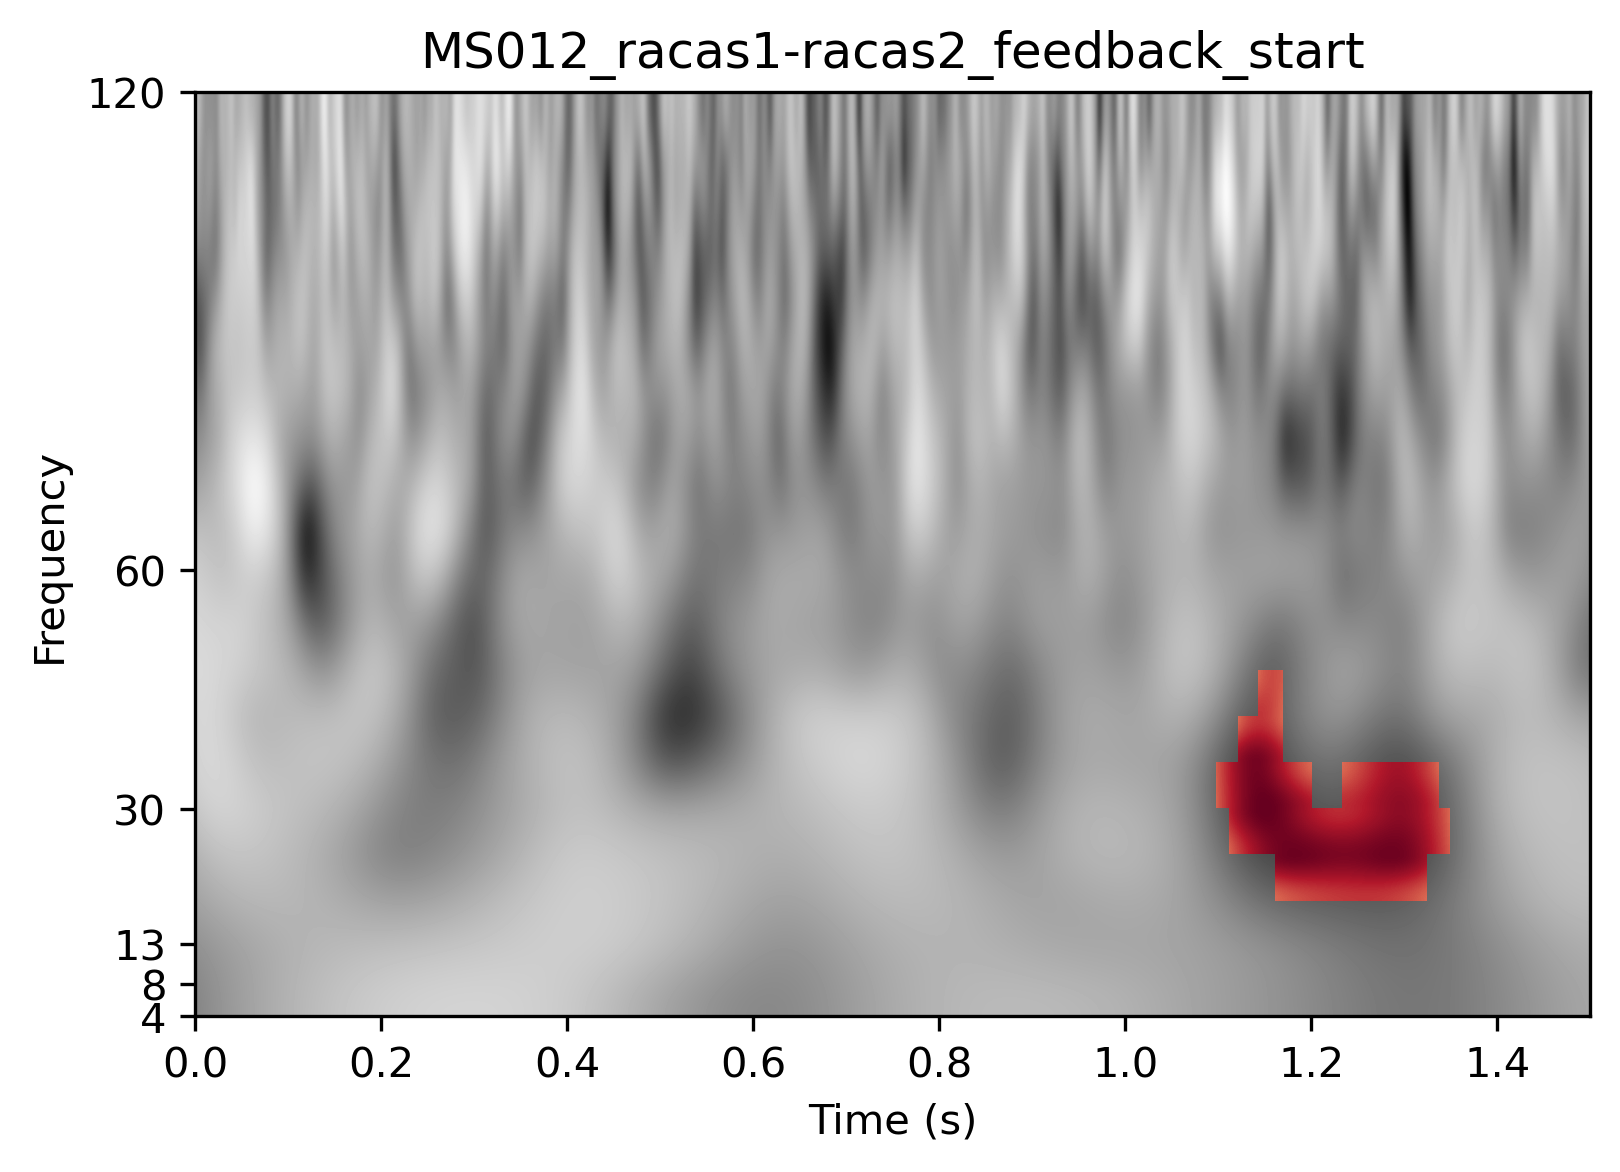

In [66]:
subj_id = 'MS012'
# region = 'frontal'

# save_path = f'{base_dir}/projects/guLab/Salman/EphysAnalyses/{subj_id}'
# # Get electrode df 
# elec_path = f'{base_dir}/projects/guLab/Salman/EMU/{subj_id}/anat/'
# # electrode files could either be csv or excel
# elec_files = glob(f'{elec_path}/*.csv') + glob(f'{elec_path}/*.xlsx')
# # There should really only be one 
# elec_file = elec_files[0]
# elec_data = lfp_preprocess_utils.load_elec(elec_file)

# anode_list = [x.split('-')[0] for x in epochs_all_subjs_all_evs[subj_id][event].ch_names]
# elec_df = elec_data[elec_data.label.str.lower().isin(anode_list)]
# # Shawn noticed the following would incorrectl y label electrodes if they're not in the same order as .ch_names! 
# # elec_df['label'] = epochs_all_subjs_all_evs[subj_id][event].ch_names
# # Fix: 
# elec_df['label'] = elec_df['label'].apply(lambda x: next((string for string in epochs_all_subjs_all_evs[subj_id][event].ch_names if x in string), np.nan))
    
# picks = analysis_utils.select_picks_rois(elec_df, region)

for event in analysis_evs:
    
    # Average the data in each condition across channels 
    X = np.nanmean(power_epochs[subj_id][event].copy().pick_channels([chan]).data, axis=1)
    
    F_obs, clusters, cluster_p_values, H0 = \
    mne.stats.permutation_cluster_1samp_test(X, n_permutations=500, out_type='mask', verbose=True)
    
    if any(cluster_p_values<=0.05):
#     print(region)
        # Create new stats image with only significant clusters
        fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=300)

        times =  power_epochs[subj_id][event].times


        # Average the data in each condition across epochs for plotting
        evoked_power = np.nanmean(X, axis=0)
    #     evoked_power_2 = np.nanmean(X[1], axis=0)
    #     evoked_power_contrast = evoked_power_1 - evoked_power_2
        signs = np.sign(evoked_power)

        F_obs_plot = np.nan * np.ones_like(F_obs)
        for c, p_val in zip(clusters, cluster_p_values):
            if p_val <= 0.05:
                F_obs_plot[c] = F_obs[c] * signs[c]

        ax.imshow(F_obs,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]], interpolation = 'Bicubic',
                  aspect='auto', origin='lower', cmap='gray')
        max_F = np.nanmax(abs(F_obs_plot))
        ax.imshow(F_obs_plot,
                  extent=[times[0], times[-1], freqs[0], freqs[-1]],
                  aspect='auto', origin='lower', cmap='RdBu_r',
                  vmin=-max_F, vmax=max_F)

        ax.set(yticks=yticks, xlabel='Time (s)', ylabel='Frequency', title=f'{subj_id}_{chan}_{event}')

            # # ax.set_title(f'Induced power ({ch_name})')
    
    